# Bayesian SIR Model with Change Points

In [2]:
import numpy as np
from scipy.stats import binom, gamma, beta, expon, poisson, uniform, bernoulli
from joblib import Parallel, delayed
from scipy.special import gamma as gammaFunc
import random

import pandas as pd
import matplotlib.pyplot as plt

import tqdm
import itertools

## Data Simulation

In [4]:
def sim_dataset(chg_pt, scenarios, T, S0, I0, R0, n_datasets):

    N = S0 + I0 + R0
    n_sc = scenarios.shape[0]

    # create array of transmission and removal rate parameters at each time step
    beta  = np.array([[scenarios[i,(chg_pt <= t+1).sum(),0] for t in range(T)] for i in range(n_sc)])
    gamma = np.array([[scenarios[i,(chg_pt <= t+1).sum(),1] for t in range(T)] for i in range(n_sc)])


    Delta_I = np.zeros(shape=(n_datasets, n_sc, T), dtype=np.int32)
    Delta_R = np.zeros(shape=(n_datasets, n_sc, T), dtype=np.int32)
    S       = np.zeros(shape=(n_datasets, n_sc, T), dtype=np.int32)
    I       = np.zeros(shape=(n_datasets, n_sc, T), dtype=np.int32)
    R       = np.zeros(shape=(n_datasets, n_sc, T), dtype=np.int32)

    Delta_I[:,:,0] = binom.rvs(S0, 1-np.exp(-beta[:,0]*I0/N), size=(n_datasets, n_sc))
    Delta_R[:,:,0] = binom.rvs(I0, gamma[:,0], size=(n_datasets, n_sc))
    S[:,:,0]       = S0 - Delta_I[:,:,0]
    I[:,:,0]       = I0 + Delta_I[:,:,0] - Delta_R[:,:,0]
    R[:,:,0]       = R0 + Delta_R[:,:,0]

    for t in range(1, T):
        Delta_I[:,:,t] = binom.rvs(S[:,:,t-1], 1-np.exp(-beta[:,t]*I[:,:,t-1]/N))
        Delta_R[:,:,t] = binom.rvs(I[:,:,t-1], gamma[:,t])
        S[:,:,t]       = S[:,:,t-1] - Delta_I[:,:,t]
        I[:,:,t]       = I[:,:,t-1] + Delta_I[:,:,t] - Delta_R[:,:,t]
        R[:,:,t]       = R[:,:,t-1] + Delta_R[:,:,t]

    return Delta_I, Delta_R, S, I, R

In [5]:
def plot_SRI(S, I, R, sc=0, d=None, start_cond=(999_950, 50, 0), tot=1_000_000, time=100):

    if d is None:
        S = np.expand_dims(np.mean(S, axis=0), 0)
        I = np.expand_dims(np.mean(I, axis=0), 0)
        R = np.expand_dims(np.mean(R, axis=0), 0)
        d = 0

    S = np.concatenate([[start_cond[0]], S[d,sc]])
    I = np.concatenate([[start_cond[1]], I[d,sc]])
    R = np.concatenate([[start_cond[2]], R[d,sc]])

    # plot
    fig, ax = plt.subplots()

    y = np.vstack([S, I, R])
    ax.stackplot(np.arange(time+1), y/tot, labels=["S","I","R"], alpha=0.8)

    ax.set_xlabel("Day")
    ax.set_ylabel("Proportion")
    ax.set_xticks(np.concatenate([[0], np.arange(25, time+1, 25)]))
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.legend(loc="upper right")

    plt.show()

### Example

In [6]:
T = 100
N = 1_000_000

chg_pt = np.array([26, 51, 76])

sc_1 = [(0.3, 0.05), (0.4, 0.15), (0.25, 0.2),  (0.2,  0.25)]
sc_2 = [(0.4, 0.1),  (0.4, 0.25), (0.25, 0.25), (0.25, 0.4) ]
sc_3 = [(0.5, 0.1),  (0.3, 0.3),  (0.4,  0.2),  (0.2,  0.4) ]
scenarios = np.array([sc_1, sc_2, sc_3])

S0 = N-50
I0 = 50
R0 = 0

n_datasets = 100

Scenario 1:


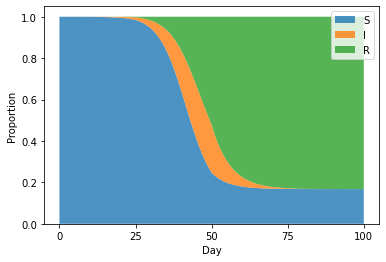

Scenario 2:


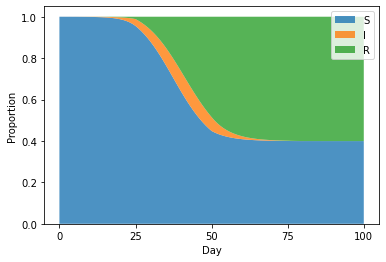

Scenario 3:


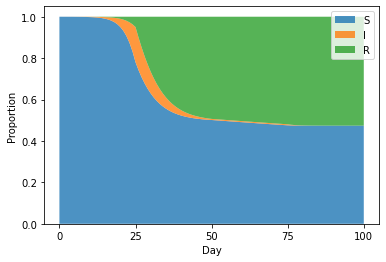

In [7]:
Delta_I, Delta_R, S, I, R =  sim_dataset(chg_pt, scenarios, T, S0, I0, R0, n_datasets)
for i in range(len(scenarios)):
    print(f"Scenario {i+1}:")
    plot_SRI(S, I, R, sc=i)

## Gibbs Sampling

In [8]:
S_obs = np.concatenate(([S0],S[0,0]))
I_obs = np.concatenate(([I0],I[0,0]))
R_obs = np.concatenate(([R0],R[0,0]))
PI_obs = I_obs/N
N_infect_obs = np.concatenate(([I0],Delta_I[0,0]))
N_recovery_obs = np.concatenate(([R0],Delta_R[0,0]))

data = pd.DataFrame({
        'susceptible': S_obs,
        'infects': I_obs,
        'recovered': R_obs,
        'PI': PI_obs,
        'deltaI': N_infect_obs,
        'deltaR': N_recovery_obs
    })

In [9]:
data

,susceptible,infects,recovered,PI,deltaI,deltaR
0,999950,50,0,0.000050,50,0
1,999937,62,1,0.000062,13,1
2,999917,76,7,0.000076,20,6
3,999895,97,8,0.000097,22,1
4,999871,118,11,0.000118,24,3
...,...,...,...,...,...,...
96,169685,20,830295,0.000020,2,8
97,169685,16,830299,0.000016,0,4
98,169684,10,830306,0.000010,1,7
99,169684,7,830309,0.000007,0,3


### Functions

In [80]:
def delta_sampling(Delta_hat,Stage_hat,K_hat,p,beta_hat,gamma_hat,T_max=100):
    
    ########## change type
    ## add–delete–swap - proposal step
    # -1 delete
    # 0 swap
    # +1 add
    if K_hat==1:
            change_type = 1
        
    elif K_hat==T_max:
        change_type = -1

    else:
        change_type = np.random.choice([-1, 0, 1])
            
    Delta_hat_candidate = Delta_hat.copy()
    
    ########## proposal phase
    if change_type != 0:
        if change_type == 1:
            possible_change_indices = np.where(Delta_hat[1:] == 0)[0]+1
        if change_type == -1:
            possible_change_indices = np.where(Delta_hat[1:] == 1)[0]+1
            
        index_to_change = np.random.choice(possible_change_indices)
            
        Delta_hat_candidate[index_to_change] = 1 - Delta_hat_candidate[index_to_change]
        Stage_hat_candidate = np.cumsum(Delta_hat_candidate)-1
            
    else:
    
        possible_change_indices = np.where(np.abs(Delta_hat[1:-1] - Delta_hat[2:]) == 1)[0]+1
        one_index = Delta_hat[possible_change_indices]
        index_to_change = np.random.choice(possible_change_indices)

        Delta_hat_candidate[index_to_change + np.array([0, 1])] = Delta_hat_candidate[index_to_change + np.array([1, 0])]
        Stage_hat_candidate = np.cumsum(Delta_hat_candidate)-1
    
    print("Original:",np.where(Delta_hat==1)[0])
    print("Candidate:",np.where(Delta_hat_candidate==1)[0])
    print("---------------------------")
    ########## metropolis hastings phase
    #compute pi(delta*)/pi(delta^g)
    pi = (p/(1-p))**(np.sum(Delta_hat_candidate - Delta_hat))
        
    #compute J/J
    JJ = 0
    delta_sum_candidate = np.sum(Delta_hat_candidate)
    delta_sum = np.sum(Delta_hat)
    if delta_sum == delta_sum_candidate:
        JJ = 1 
    elif ([delta_sum_candidate, delta_sum] == [1, 2] or [delta_sum_candidate, delta_sum] == [T_max, T_max-1]):
        JJ = 3/(T_max-1)
    elif ([delta_sum_candidate, delta_sum] == [2, 1] or [delta_sum_candidate, delta_sum] == [T_max-1, T_max]):
        JJ = (T_max-1)/3
    elif delta_sum_candidate - delta_sum == -1 and (delta_sum_candidate != 1 and delta_sum_candidate != T_max-1):
        JJ = (delta_sum-1)/(T_max - delta_sum_candidate)
    elif delta_sum_candidate - delta_sum == 1 and (delta_sum_candidate != 2 and delta_sum_candidate != T_max):
        JJ = (T_max - delta_sum)/(delta_sum_candidate-1)

    #compute pi(beta,gamma|delta*)/pi(beta,gamma|delta)
    log1_candidate = 0
    log2_candidate = 0
        
    for k in range(np.sum(Delta_hat_candidate)):
        ind_k = np.where(Stage_hat_candidate == k)[0]
        log1_candidate += np.log(gammaFunc(0.1+len(ind_k))) - (0.1+len(ind_k))*np.log(0.1+np.sum(beta_hat[ind_k]))
        log2_candidate += np.log(gammaFunc(0.1+len(ind_k))) - (0.1+len(ind_k))*np.log(0.1+np.sum(-np.log(gamma_hat[ind_k])))
        
    log1_original = 0
    log2_original = 0
                                     
    for k in range(np.sum(Delta_hat)):
        ind_k = np.where(Stage_hat == k)[0]
        
        print(len(ind_k))
        log1_original += np.log(gammaFunc(0.1+len(ind_k))) - (0.1+len(ind_k))*np.log(0.1+np.sum(beta_hat[ind_k]))
        log2_original += np.log(gammaFunc(0.1+len(ind_k))) - (0.1+len(ind_k))*np.log(0.1+np.sum(-np.log(gamma_hat[ind_k])))
        
    log_final = (log1_candidate+log2_candidate) - (log1_original+log2_original)     
        
    intermediate_ratio = np.exp(log_final)
    m_mh = intermediate_ratio*JJ*pi
    ratio = min(1.,m_mh)
    print("ratio:",ratio)
    print("intermediate_ratio:",intermediate_ratio)
    print("JJ:",JJ)
    print("pi:",pi)
    print("likelihood_original:",np.exp(log1_original+log2_original))
    cxx = np.random.binomial(1, ratio) 
        
    if cxx == 1:
        Delta_hat = Delta_hat_candidate
        Stage_hat = Stage_hat_candidate
        K_hat = delta_sum_candidate
        
    return Delta_hat,Stage_hat,K_hat

In [107]:
#(gammaFunc(100.1))/(((100.1)**(100.1))*((0.1-100*np.log(0.9))**(100.1)))*(gammaFunc(100.1))

2067489455.6969686

In [101]:
T_max = 100
Delta_hat = np.zeros(T_max,dtype=int)
Delta_hat[0] = 1
Stage_hat = np.cumsum(Delta_hat)-1
K_hat = np.sum(Delta_hat)

beta_hat = np.ones(T_max)
gamma_hat = np.ones(T_max)*0.9

p=0.01

Delta_hat, Stage_hat, K_hat = delta_sampling(Delta_hat,Stage_hat,K_hat,p,beta_hat,gamma_hat)

Original: [0]
Candidate: [ 0 26]
---------------------------
100
ratio: 0.04859351466658577
intermediate_ratio: 0.1457805439997573
JJ: 33.0
pi: 0.010101010101010102
likelihood_original: 2067489455.6968567


In [11]:
def calculate_contact_hat_parallel(pp_lambda_t):
    pp, lambda_t = pp_lambda_t
    return np.sum(poisson.ppf(pp, lambda_t))

### Gibbs

In [138]:
def gibbs_sampling(data, p=0.01,samples=10000, T_max=100, burnin=1000, thinning=10):
    
    ############# data
    # Data is expected to be a dataframe with 101 rows (100 steps + initial one)
    # OBS: the initial row should display the starting values 
    #      for Susceptible (S), Infected (I), and Recovered (R), with zero values in the 
    #      columns representing changes (deltas) over time.
    
    I_obs = data["infects"].values
    S_obs = data["susceptible"].values
    PI_obs = data["PI"].values
    N_infect_obs = data["deltaI"].values[1:]
    N_recovery_obs = data["deltaR"].values[1:]
    

    #######################
    ##  HYPERPARAMETERS  ##
    #######################
    
    b_shape = 0.1
    b_rate = 0.1
    r_shape = 0.1
    r_rate = 0.1    

    ######################
    ##  INITIALIZATION  ##
    ######################
    
    ##### delta
    Delta_hat = np.zeros(T_max,dtype=int)
    Delta_hat[0] = 1
    Stage_hat = np.cumsum(Delta_hat, dtype=int)-1
    K_hat     = np.sum(Delta_hat, dtype=int)

    ##### b and r
    b_hat    = gamma.rvs(a=b_shape, scale=1/b_rate, size=K_hat)
    r_hat    = gamma.rvs(a=r_shape, scale=1/r_rate, size=K_hat)
    
    ##### beta and gamma
    beta_hat    = expon.rvs(scale=1/b_hat[Stage_hat[0]], size=T_max)
    gamma_hat   = beta.rvs(a=r_hat[Stage_hat[0]], b=1, size=T_max)
    lambda_t    = beta_hat*PI_obs[:-1]
    p_upper     = 1 - poisson.cdf(0, lambda_t)
    pp          = [uniform.rvs(size=N_infect_obs[t]) * p_upper[t] + (1 - p_upper[t]) for t in range(T_max)]
    contact_hat = np.array(Parallel(n_jobs=-1)(delayed(calculate_contact_hat_parallel)((pp[t], lambda_t[t],)) for t in range(T_max)))
    
    
    beta_hat    = gamma.rvs(a=contact_hat + 1, scale=1/(b_hat[Stage_hat] + PI_obs[:-1]*S_obs[:-1]))
    gamma_hat   = beta.rvs(a=N_recovery_obs + r_hat[Stage_hat], b=1 + I_obs[:-1] - N_recovery_obs)
    lambda_t    = beta_hat * PI_obs[:-1]
    p_upper     = 1 - poisson.cdf(0, lambda_t)
    pp          = [uniform.rvs(size=N_infect_obs[t]) * p_upper[t] + (1 - p_upper[t]) for t in range(T_max)]
    contact_hat = np.array(Parallel(n_jobs=-1)(delayed(calculate_contact_hat_parallel)((pp[t], lambda_t[t],)) for t in range(T_max)))
    
    
    print("Initialization:\n")
    print("Delta_hat:",Delta_hat)
    print("b_hat:",b_hat)
    print("r_hat:",r_hat)
    print("beta_hat:",beta_hat)
    print("gamma_hat:",gamma_hat)
    print("----------------------------------------------------")
    print("----------------------------------------------------")
    

    ################
    ##  SAMPLING  ##
    ################
    
    Delta_all = []
    Stage_all = []
    b_all     = []
    r_all     = []
    beta_all  = []
    gamma_all = []
    
    for step in tqdm.tqdm(range(samples)):
        
        ###### delta_hat sampling
                
        Delta_hat, Stage_hat, K_hat = delta_sampling(Delta_hat,Stage_hat,K_hat,p,beta_hat,gamma_hat)
                                  
        ##### b and r sampling
        
        b_hat = np.zeros(K_hat)
        r_hat = np.zeros(K_hat)
        for i in range(K_hat):
            L_i = np.where(Stage_hat == i)[0]
            b_hat[i] = gamma.rvs(size=1, a=(b_shape + len(L_i)), scale=1/(b_rate + np.sum(beta_hat[L_i])))
            r_hat[i] = gamma.rvs(size=1, a=(r_shape + len(L_i)), scale=1/(r_rate + np.sum(-np.log(gamma_hat[L_i]))))
    
        
        ##### beta and gamma sampling

        beta_hat    = gamma.rvs(a=contact_hat + 1, scale=1/(b_hat[Stage_hat] + PI_obs[:-1]*S_obs[:-1]))
        gamma_hat   = beta.rvs(a=N_recovery_obs + r_hat[Stage_hat], b=1 + I_obs[:-1] - N_recovery_obs)
        lambda_t    = beta_hat * PI_obs[:-1]
        p_upper     = 1 - poisson.cdf(0, lambda_t)
        pp          = [uniform.rvs(size=N_infect_obs[t]) * p_upper[t] + (1 - p_upper[t]) for t in range(T_max)]
        contact_hat = np.array(Parallel(n_jobs=-1)(delayed(calculate_contact_hat_parallel)((pp[t], lambda_t[t],)) for t in range(T_max)))
    
        if step % 100 == 0 and step != 0:
            print("\nStep:",step)
            #print("Delta_hat:",Delta_hat)
            #print("b_hat:",b_hat)
            #print("r_hat:",r_hat)
            #print("beta_hat:",beta_hat)
            #print("gamma_hat:",gamma_hat)
            print("----------------------------------------------------")
            
        Delta_all.append(Delta_hat)
        Stage_all.append(Stage_hat)
        b_all.append(b_hat)
        r_all.append(r_hat)
        beta_all.append(beta_hat)
        gamma_all.append(gamma_hat)
  
    # Creazione del DataFrame
    MCMC_chain = {
        'Delta': Delta_all[burnin::thinning],
        'Stage': Stage_all[burnin::thinning],
        'b': b_all[burnin::thinning],
        'r': r_all[burnin::thinning],
        'beta': beta_all[burnin::thinning],
        'gamma': gamma_all[burnin::thinning]
            }
    
    return MCMC_chain

In [140]:
MCMC_chain=gibbs_sampling(data, p=0.01,samples=650, burnin=50, thinning=3)

Initialization:

Delta_hat: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
b_hat: [0.7074441]
r_hat: [0.01321713]
beta_hat: [0.3126258  0.37351176 0.32322012 0.27643223 0.32936979 0.25791684
 0.32577987 0.33849252 0.36655114 0.28428002 0.32473981 0.26730881
 0.26586469 0.2540368  0.30202967 0.30800688 0.3283289  0.31183168
 0.29444476 0.28917267 0.29076936 0.3002374  0.28915149 0.31146479
 0.32366895 0.40405367 0.39746407 0.39802888 0.39280017 0.40861544
 0.39767972 0.40436917 0.46414389 0.39736702 0.41606052 0.40180793
 0.51683915 0.40926621 0.3946753  0.47162544 0.41912889 0.64142755
 0.40918379 0.41122911 0.39215043 0.4230985  0.44014885 0.49338454
 0.51629007 0.44185591 0.24733301 0.25321538 0.24322788 0.29255242
 0.24107639 0.25218915 0.25963409 0.25311151 0.2641984  0.26023585
 0.26733943 0.26584389 0.24132598 0.25380988 0.23


  0%|                                                        | 0/650 [00:00<?, ?it/s]

Original: [0]
Candidate: [ 0 37]
---------------------------
ratio: 1.0



  0%|                                                | 1/650 [00:00<08:44,  1.24it/s]

Original: [ 0 37]
Candidate: [ 0 18 37]
---------------------------
ratio: 0.3984844049676498



  0%|▏                                               | 2/650 [00:01<08:12,  1.32it/s]

Original: [ 0 37]
Candidate: [ 0 37 46]
---------------------------
ratio: 0.7878595013878762



  0%|▏                                               | 3/650 [00:02<08:00,  1.35it/s]

Original: [ 0 37 46]
Candidate: [ 0 37 46 86]
---------------------------
ratio: 0.3437718797185113



  1%|▎                                               | 4/650 [00:02<07:58,  1.35it/s]

Original: [ 0 37 46 86]
Candidate: [ 0 37 46 50 86]
---------------------------
ratio: 0.6321365772720581



  1%|▎                                               | 5/650 [00:03<07:54,  1.36it/s]

Original: [ 0 37 46 86]
Candidate: [ 0 37 46 63 86]
---------------------------
ratio: 0.14701006550678342



  1%|▍                                               | 6/650 [00:04<07:54,  1.36it/s]

Original: [ 0 37 46 86]
Candidate: [ 0 37 46]
---------------------------
ratio: 1.0



  1%|▌                                               | 7/650 [00:05<07:54,  1.36it/s]

Original: [ 0 37 46]
Candidate: [ 0 37 45]
---------------------------
ratio: 1.0



  1%|▌                                               | 8/650 [00:05<07:55,  1.35it/s]

Original: [ 0 37 45]
Candidate: [ 0 37 45 64]
---------------------------
ratio: 0.1696589585163591



  1%|▋                                               | 9/650 [00:06<07:59,  1.34it/s]

Original: [ 0 37 45]
Candidate: [ 0 37 44]
---------------------------
ratio: 1.0



  2%|▋                                              | 10/650 [00:07<07:59,  1.33it/s]

Original: [ 0 37 44]
Candidate: [ 0 37 45]
---------------------------
ratio: 0.9907414725643535



  2%|▊                                              | 11/650 [00:08<07:59,  1.33it/s]

Original: [ 0 37 45]
Candidate: [ 0 37 46]
---------------------------
ratio: 1.0



  2%|▊                                              | 12/650 [00:08<08:01,  1.32it/s]

Original: [ 0 37 46]
Candidate: [ 0 34 37 46]
---------------------------
ratio: 0.7152959265298864



  2%|▉                                              | 13/650 [00:09<07:59,  1.33it/s]

Original: [ 0 37 46]
Candidate: [ 0 46]
---------------------------
ratio: 1.0



  2%|█                                              | 14/650 [00:10<08:00,  1.32it/s]

Original: [ 0 46]
Candidate: [ 0 46 62]
---------------------------
ratio: 0.25181896258687436



  2%|█                                              | 15/650 [00:11<08:00,  1.32it/s]

Original: [ 0 46]
Candidate: [0]
---------------------------
ratio: 0.42457314151594



  2%|█▏                                             | 16/650 [00:12<07:59,  1.32it/s]

Original: [ 0 46]
Candidate: [0]
---------------------------
ratio: 0.37594876763778623



  3%|█▏                                             | 17/650 [00:12<08:00,  1.32it/s]

Original: [0]
Candidate: [ 0 24]
---------------------------
ratio: 1.0



  3%|█▎                                             | 18/650 [00:13<07:58,  1.32it/s]

Original: [ 0 24]
Candidate: [ 0 24 97]
---------------------------
ratio: 0.9512965132679545



  3%|█▎                                             | 19/650 [00:14<08:13,  1.28it/s]

Original: [ 0 24 97]
Candidate: [ 0 23 97]
---------------------------
ratio: 0.8237092671521433



  3%|█▍                                             | 20/650 [00:15<08:14,  1.27it/s]

Original: [ 0 24 97]
Candidate: [ 0 24]
---------------------------
ratio: 0.1909770399825632



  3%|█▌                                             | 21/650 [00:15<08:11,  1.28it/s]

Original: [ 0 24 97]
Candidate: [ 0 24 62 97]
---------------------------
ratio: 0.23156302993222413



  3%|█▌                                             | 22/650 [00:16<08:09,  1.28it/s]

Original: [ 0 24 97]
Candidate: [ 0 97]
---------------------------
ratio: 0.1760680825270368



  4%|█▋                                             | 23/650 [00:17<08:07,  1.29it/s]

Original: [ 0 24 97]
Candidate: [ 0 24]
---------------------------
ratio: 1.0



  4%|█▋                                             | 24/650 [00:18<08:04,  1.29it/s]

Original: [ 0 24]
Candidate: [0]
---------------------------
ratio: 0.5043453856015842



  4%|█▊                                             | 25/650 [00:19<08:02,  1.30it/s]

Original: [ 0 24]
Candidate: [ 0 22 24]
---------------------------
ratio: 1.0



  4%|█▉                                             | 26/650 [00:19<08:01,  1.30it/s]

Original: [ 0 22 24]
Candidate: [ 0 21 24]
---------------------------
ratio: 0.6916921168471531



  4%|█▉                                             | 27/650 [00:20<08:01,  1.29it/s]

Original: [ 0 22 24]
Candidate: [ 0 22]
---------------------------
ratio: 0.5491386186474867



  4%|██                                             | 28/650 [00:21<08:01,  1.29it/s]

Original: [ 0 22]
Candidate: [0]
---------------------------
ratio: 0.36499230236279323



  4%|██                                             | 29/650 [00:22<08:00,  1.29it/s]

Original: [0]
Candidate: [ 0 53]
---------------------------
ratio: 1.0



  5%|██▏                                            | 30/650 [00:22<07:59,  1.29it/s]

Original: [ 0 53]
Candidate: [ 0 54]
---------------------------
ratio: 0.8905160312549928



  5%|██▏                                            | 31/650 [00:23<08:02,  1.28it/s]

Original: [ 0 54]
Candidate: [0]
---------------------------
ratio: 0.28182195909567154



  5%|██▎                                            | 32/650 [00:24<08:01,  1.28it/s]

Original: [ 0 54]
Candidate: [0]
---------------------------
ratio: 0.1249428567832881



  5%|██▍                                            | 33/650 [00:25<08:10,  1.26it/s]

Original: [ 0 54]
Candidate: [ 0 54 64]
---------------------------
ratio: 0.28863597431997284



  5%|██▍                                            | 34/650 [00:26<08:09,  1.26it/s]

Original: [ 0 54]
Candidate: [0]
---------------------------
ratio: 0.24121178038399296



  5%|██▌                                            | 35/650 [00:26<08:16,  1.24it/s]

Original: [0]
Candidate: [ 0 98]
---------------------------
ratio: 1.0



  6%|██▌                                            | 36/650 [00:27<08:12,  1.25it/s]

Original: [ 0 98]
Candidate: [ 0 94 98]
---------------------------
ratio: 0.6618334576807671



  6%|██▋                                            | 37/650 [00:28<08:07,  1.26it/s]

Original: [ 0 98]
Candidate: [0]
---------------------------
ratio: 0.9872130210393643



  6%|██▋                                            | 38/650 [00:29<08:05,  1.26it/s]

Original: [0]
Candidate: [ 0 65]
---------------------------
ratio: 0.9179693612900159



  6%|██▊                                            | 39/650 [00:30<08:02,  1.27it/s]

Original: [ 0 65]
Candidate: [ 0 64]
---------------------------
ratio: 1.0



  6%|██▉                                            | 40/650 [00:30<08:00,  1.27it/s]

Original: [ 0 64]
Candidate: [0]
---------------------------
ratio: 0.7582257243141122



  6%|██▉                                            | 41/650 [00:31<08:04,  1.26it/s]

Original: [0]
Candidate: [ 0 47]
---------------------------
ratio: 1.0



  6%|███                                            | 42/650 [00:32<08:00,  1.26it/s]

Original: [ 0 47]
Candidate: [ 0 47 72]
---------------------------
ratio: 0.19426043903228649



  7%|███                                            | 43/650 [00:33<07:58,  1.27it/s]

Original: [ 0 47]
Candidate: [ 0 46]
---------------------------
ratio: 0.9101197131573487



  7%|███▏                                           | 44/650 [00:33<07:57,  1.27it/s]

Original: [ 0 46]
Candidate: [ 0 47]
---------------------------
ratio: 1.0



  7%|███▎                                           | 45/650 [00:34<07:57,  1.27it/s]

Original: [ 0 47]
Candidate: [0]
---------------------------
ratio: 0.2762396941116881



  7%|███▎                                           | 46/650 [00:35<07:59,  1.26it/s]

Original: [ 0 47]
Candidate: [ 0 47 81]
---------------------------
ratio: 0.18267283671714793



  7%|███▍                                           | 47/650 [00:36<07:59,  1.26it/s]

Original: [ 0 47]
Candidate: [ 0 47 63]
---------------------------
ratio: 0.2174022642775034



  7%|███▍                                           | 48/650 [00:37<07:58,  1.26it/s]

Original: [ 0 47]
Candidate: [0]
---------------------------
ratio: 0.4350617325084551



  8%|███▌                                           | 49/650 [00:37<07:56,  1.26it/s]

Original: [ 0 47]
Candidate: [ 0 46]
---------------------------
ratio: 0.9487403502182842



  8%|███▌                                           | 50/650 [00:38<07:56,  1.26it/s]

Original: [ 0 46]
Candidate: [0]
---------------------------
ratio: 0.2117734470242907



  8%|███▋                                           | 51/650 [00:39<07:55,  1.26it/s]

Original: [ 0 46]
Candidate: [ 0 46 54]
---------------------------
ratio: 0.5165508540618325



  8%|███▊                                           | 52/650 [00:40<07:56,  1.25it/s]

Original: [ 0 46 54]
Candidate: [ 0 46]
---------------------------
ratio: 1.0



  8%|███▊                                           | 53/650 [00:41<07:55,  1.26it/s]

Original: [ 0 46]
Candidate: [ 0 46 59]
---------------------------
ratio: 0.2744921757341576



  8%|███▉                                           | 54/650 [00:41<07:55,  1.25it/s]

Original: [ 0 46]
Candidate: [0]
---------------------------
ratio: 0.390909787853168



  8%|███▉                                           | 55/650 [00:42<08:00,  1.24it/s]

Original: [0]
Candidate: [ 0 56]
---------------------------
ratio: 1.0



  9%|████                                           | 56/650 [00:43<08:05,  1.22it/s]

Original: [ 0 56]
Candidate: [0]
---------------------------
ratio: 0.561062821259675



  9%|████                                           | 57/650 [00:44<08:07,  1.22it/s]

Original: [ 0 56]
Candidate: [ 0 56 65]
---------------------------
ratio: 0.3126272802800606



  9%|████▏                                          | 58/650 [00:45<08:03,  1.22it/s]

Original: [ 0 56]
Candidate: [ 0  3 56]
---------------------------
ratio: 0.9675523499605025



  9%|████▎                                          | 59/650 [00:46<08:06,  1.21it/s]

Original: [ 0  3 56]
Candidate: [ 0  3 55]
---------------------------
ratio: 1.0



  9%|████▎                                          | 60/650 [00:46<08:05,  1.21it/s]

Original: [ 0  3 55]
Candidate: [ 0 55]
---------------------------
ratio: 1.0



  9%|████▍                                          | 61/650 [00:47<08:01,  1.22it/s]

Original: [ 0 55]
Candidate: [ 0 28 55]
---------------------------
ratio: 0.7849578923516803



 10%|████▍                                          | 62/650 [00:48<08:00,  1.22it/s]

Original: [ 0 28 55]
Candidate: [ 0 27 55]
---------------------------
ratio: 1.0



 10%|████▌                                          | 63/650 [00:49<07:58,  1.23it/s]

Original: [ 0 27 55]
Candidate: [ 0 28 55]
---------------------------
ratio: 0.9092351999492474



 10%|████▋                                          | 64/650 [00:50<07:56,  1.23it/s]

Original: [ 0 28 55]
Candidate: [ 0 28 54]
---------------------------
ratio: 1.0



 10%|████▋                                          | 65/650 [00:50<07:54,  1.23it/s]

Original: [ 0 28 54]
Candidate: [ 0 54]
---------------------------
ratio: 1.0



 10%|████▊                                          | 66/650 [00:51<07:52,  1.24it/s]

Original: [ 0 54]
Candidate: [ 0 53]
---------------------------
ratio: 1.0



 10%|████▊                                          | 67/650 [00:52<07:52,  1.23it/s]

Original: [ 0 53]
Candidate: [ 0 52]
---------------------------
ratio: 1.0



 10%|████▉                                          | 68/650 [00:53<07:51,  1.24it/s]

Original: [ 0 52]
Candidate: [ 0 52 83]
---------------------------
ratio: 0.19484654308796218



 11%|████▉                                          | 69/650 [00:54<07:52,  1.23it/s]

Original: [ 0 52]
Candidate: [ 0 52 66]
---------------------------
ratio: 0.23774300753283836



 11%|█████                                          | 70/650 [00:55<07:51,  1.23it/s]

Original: [ 0 52]
Candidate: [0]
---------------------------
ratio: 0.23223295939244873



 11%|█████▏                                         | 71/650 [00:55<07:59,  1.21it/s]

Original: [ 0 52]
Candidate: [ 0 36 52]
---------------------------
ratio: 0.4773000588886974



 11%|█████▏                                         | 72/650 [00:56<07:55,  1.21it/s]

Original: [ 0 52]
Candidate: [0]
---------------------------
ratio: 0.11615020484487729



 11%|█████▎                                         | 73/650 [00:57<07:52,  1.22it/s]

Original: [ 0 52]
Candidate: [ 0 28 52]
---------------------------
ratio: 0.6773454112549916



 11%|█████▎                                         | 74/650 [00:58<07:50,  1.22it/s]

Original: [ 0 28 52]
Candidate: [ 0 28 52 53]
---------------------------
ratio: 1.0



 12%|█████▍                                         | 75/650 [00:59<07:49,  1.22it/s]

Original: [ 0 28 52 53]
Candidate: [ 0 29 52 53]
---------------------------
ratio: 0.9214913635792962



 12%|█████▍                                         | 76/650 [00:59<07:47,  1.23it/s]

Original: [ 0 29 52 53]
Candidate: [ 0 29 52 53 75]
---------------------------
ratio: 0.10737698552130504



 12%|█████▌                                         | 77/650 [01:00<07:46,  1.23it/s]

Original: [ 0 29 52 53]
Candidate: [ 0 30 52 53]
---------------------------
ratio: 0.9207324946378905



 12%|█████▋                                         | 78/650 [01:01<07:44,  1.23it/s]

Original: [ 0 30 52 53]
Candidate: [ 0 20 30 52 53]
---------------------------
ratio: 0.1988335926010207



 12%|█████▋                                         | 79/650 [01:02<07:42,  1.23it/s]

Original: [ 0 30 52 53]
Candidate: [ 0  1 30 52 53]
---------------------------
ratio: 1.0



 12%|█████▊                                         | 80/650 [01:03<07:42,  1.23it/s]

Original: [ 0  1 30 52 53]
Candidate: [ 0  1 30 51 53]
---------------------------
ratio: 0.5597972717857059



 12%|█████▊                                         | 81/650 [01:04<08:20,  1.14it/s]

Original: [ 0  1 30 51 53]
Candidate: [ 0  1 30 33 51 53]
---------------------------
ratio: 0.36547612273962343



 13%|█████▉                                         | 82/650 [01:05<09:48,  1.04s/it]

Original: [ 0  1 30 51 53]
Candidate: [ 0  1 51 53]
---------------------------
ratio: 1.0



 13%|██████                                         | 83/650 [01:07<10:59,  1.16s/it]

Original: [ 0  1 51 53]
Candidate: [ 0  1 45 51 53]
---------------------------
ratio: 0.28411527235761835



 13%|██████                                         | 84/650 [01:08<10:28,  1.11s/it]

Original: [ 0  1 51 53]
Candidate: [ 0  1 50 53]
---------------------------
ratio: 0.7652661251971647



 13%|██████▏                                        | 85/650 [01:09<10:10,  1.08s/it]

Original: [ 0  1 50 53]
Candidate: [ 0  1 50 53 57]
---------------------------
ratio: 0.2956153309528045



 13%|██████▏                                        | 86/650 [01:10<10:33,  1.12s/it]

Original: [ 0  1 50 53]
Candidate: [ 0  1 50 53 84]
---------------------------
ratio: 0.10893680941053842



 13%|██████▎                                        | 87/650 [01:11<09:46,  1.04s/it]

Original: [ 0  1 50 53]
Candidate: [ 0  1 14 50 53]
---------------------------
ratio: 0.2188797545167999



 14%|██████▎                                        | 88/650 [01:12<10:17,  1.10s/it]

Original: [ 0  1 50 53]
Candidate: [ 0  1  6 50 53]
---------------------------
ratio: 0.29913359744521234



 14%|██████▍                                        | 89/650 [01:13<09:30,  1.02s/it]

Original: [ 0  1 50 53]
Candidate: [ 0  1 53]
---------------------------
ratio: 1.0



 14%|██████▌                                        | 90/650 [01:14<08:57,  1.04it/s]

Original: [ 0  1 53]
Candidate: [ 0  1 54]
---------------------------
ratio: 0.8910366207099658



 14%|██████▌                                        | 91/650 [01:14<08:31,  1.09it/s]

Original: [ 0  1 54]
Candidate: [ 0  1 53]
---------------------------
ratio: 1.0



 14%|██████▋                                        | 92/650 [01:15<08:13,  1.13it/s]

Original: [ 0  1 53]
Candidate: [0 1]
---------------------------
ratio: 0.3876972845861588



 14%|██████▋                                        | 93/650 [01:16<08:02,  1.15it/s]

Original: [ 0  1 53]
Candidate: [ 0  2 53]
---------------------------
ratio: 0.5317047160333269



 14%|██████▊                                        | 94/650 [01:17<07:52,  1.18it/s]

Original: [ 0  1 53]
Candidate: [ 0  1 54]
---------------------------
ratio: 0.8976599550408627



 15%|██████▊                                        | 95/650 [01:18<07:45,  1.19it/s]

Original: [ 0  1 53]
Candidate: [ 0  1 21 53]
---------------------------
ratio: 0.5431999290844914



 15%|██████▉                                        | 96/650 [01:18<07:43,  1.20it/s]

Original: [ 0  1 21 53]
Candidate: [ 0  2 21 53]
---------------------------
ratio: 0.5212097582565121



 15%|███████                                        | 97/650 [01:19<07:40,  1.20it/s]

Original: [ 0  2 21 53]
Candidate: [ 0  2 21 53 75]
---------------------------
ratio: 0.11358343140171735



 15%|███████                                        | 98/650 [01:20<07:37,  1.21it/s]

Original: [ 0  2 21 53]
Candidate: [ 0  2 20 53]
---------------------------
ratio: 0.898196352003802



 15%|███████▏                                       | 99/650 [01:21<07:35,  1.21it/s]

Original: [ 0  2 21 53]
Candidate: [ 0  3 21 53]
---------------------------
ratio: 0.5725636426770789



 15%|███████                                       | 100/650 [01:22<07:33,  1.21it/s]

Original: [ 0  2 21 53]
Candidate: [ 0  2 21 53 65]
---------------------------
ratio: 0.12078355029657417



 16%|███████▏                                      | 101/650 [01:23<07:30,  1.22it/s]


Step: 100
----------------------------------------------------
Original: [ 0  2 21 53]
Candidate: [ 0  2 53]
---------------------------
ratio: 1.0



 16%|███████▏                                      | 102/650 [01:23<07:29,  1.22it/s]

Original: [ 0  2 53]
Candidate: [0 2]
---------------------------
ratio: 0.3600865215719243



 16%|███████▎                                      | 103/650 [01:24<07:29,  1.22it/s]

Original: [ 0  2 53]
Candidate: [ 0  2 52]
---------------------------
ratio: 1.0



 16%|███████▎                                      | 104/650 [01:25<07:27,  1.22it/s]

Original: [ 0  2 52]
Candidate: [ 0  3 52]
---------------------------
ratio: 0.6213576289143673



 16%|███████▍                                      | 105/650 [01:26<07:26,  1.22it/s]

Original: [ 0  3 52]
Candidate: [ 0  3 52 89]
---------------------------
ratio: 0.2974060311339915



 16%|███████▌                                      | 106/650 [01:27<07:27,  1.22it/s]

Original: [ 0  3 52]
Candidate: [0 3]
---------------------------
ratio: 0.31232199104613145



 16%|███████▌                                      | 107/650 [01:27<07:24,  1.22it/s]

Original: [ 0  3 52]
Candidate: [0 3]
---------------------------
ratio: 0.16280403081823078



 17%|███████▋                                      | 108/650 [01:28<07:23,  1.22it/s]

Original: [ 0  3 52]
Candidate: [0 3]
---------------------------
ratio: 0.15311832886679666



 17%|███████▋                                      | 109/650 [01:29<07:23,  1.22it/s]

Original: [ 0  3 52]
Candidate: [ 0  3 53]
---------------------------
ratio: 0.8788422531447144



 17%|███████▊                                      | 110/650 [01:30<07:21,  1.22it/s]

Original: [ 0  3 52]
Candidate: [0 3]
---------------------------
ratio: 0.28201265786141305



 17%|███████▊                                      | 111/650 [01:31<07:20,  1.22it/s]

Original: [0 3]
Candidate: [0 4]
---------------------------
ratio: 1.0



 17%|███████▉                                      | 112/650 [01:32<07:19,  1.22it/s]

Original: [0 4]
Candidate: [0]
---------------------------
ratio: 1.0



 17%|███████▉                                      | 113/650 [01:32<07:20,  1.22it/s]

Original: [0]
Candidate: [ 0 17]
---------------------------
ratio: 1.0



 18%|████████                                      | 114/650 [01:33<07:17,  1.22it/s]

Original: [ 0 17]
Candidate: [ 0 18]
---------------------------
ratio: 1.0



 18%|████████▏                                     | 115/650 [01:34<07:18,  1.22it/s]

Original: [ 0 18]
Candidate: [0]
---------------------------
ratio: 0.4777372577646879



 18%|████████▏                                     | 116/650 [01:35<07:17,  1.22it/s]

Original: [0]
Candidate: [ 0 47]
---------------------------
ratio: 1.0



 18%|████████▎                                     | 117/650 [01:36<07:17,  1.22it/s]

Original: [ 0 47]
Candidate: [ 0 21 47]
---------------------------
ratio: 0.6354910962313921



 18%|████████▎                                     | 118/650 [01:36<07:15,  1.22it/s]

Original: [ 0 47]
Candidate: [ 0 46]
---------------------------
ratio: 0.915001033569641



 18%|████████▍                                     | 119/650 [01:37<07:14,  1.22it/s]

Original: [ 0 46]
Candidate: [0]
---------------------------
ratio: 0.5455848183017842



 18%|████████▍                                     | 120/650 [01:38<07:13,  1.22it/s]

Original: [0]
Candidate: [ 0 10]
---------------------------
ratio: 0.76531958803471



 19%|████████▌                                     | 121/650 [01:39<07:17,  1.21it/s]

Original: [ 0 10]
Candidate: [0]
---------------------------
ratio: 1.0



 19%|████████▋                                     | 122/650 [01:40<07:18,  1.21it/s]

Original: [0]
Candidate: [ 0 11]
---------------------------
ratio: 0.5185288959304049



 19%|████████▋                                     | 123/650 [01:41<07:15,  1.21it/s]

Original: [ 0 11]
Candidate: [ 0 12]
---------------------------
ratio: 1.0



 19%|████████▊                                     | 124/650 [01:41<07:13,  1.21it/s]

Original: [ 0 12]
Candidate: [ 0 12 79]
---------------------------
ratio: 0.5341473061765786



 19%|████████▊                                     | 125/650 [01:42<07:15,  1.21it/s]

Original: [ 0 12]
Candidate: [ 0 13]
---------------------------
ratio: 1.0



 19%|████████▉                                     | 126/650 [01:43<07:13,  1.21it/s]

Original: [ 0 13]
Candidate: [0]
---------------------------
ratio: 1.0



 20%|████████▉                                     | 127/650 [01:44<07:11,  1.21it/s]

Original: [0]
Candidate: [0 9]
---------------------------
ratio: 0.6041009372405305



 20%|█████████                                     | 128/650 [01:45<07:09,  1.22it/s]

Original: [0 9]
Candidate: [0]
---------------------------
ratio: 0.9873500441861772



 20%|█████████▏                                    | 129/650 [01:46<07:08,  1.21it/s]

Original: [0]
Candidate: [ 0 67]
---------------------------
ratio: 0.3759114401423163



 20%|█████████▏                                    | 130/650 [01:46<07:06,  1.22it/s]

Original: [ 0 67]
Candidate: [0]
---------------------------
ratio: 0.4228869163300644



 20%|█████████▎                                    | 131/650 [01:47<07:05,  1.22it/s]

Original: [ 0 67]
Candidate: [0]
---------------------------
ratio: 1.0



 20%|█████████▎                                    | 132/650 [01:48<07:03,  1.22it/s]

Original: [0]
Candidate: [0 5]
---------------------------
ratio: 0.4893157767450127



 20%|█████████▍                                    | 133/650 [01:49<07:04,  1.22it/s]

Original: [0 5]
Candidate: [ 0  5 22]
---------------------------
ratio: 1.0



 21%|█████████▍                                    | 134/650 [01:50<07:02,  1.22it/s]

Original: [ 0  5 22]
Candidate: [ 0  6 22]
---------------------------
ratio: 0.9382399785011728



 21%|█████████▌                                    | 135/650 [01:50<07:00,  1.22it/s]

Original: [ 0  6 22]
Candidate: [ 0  6 23]
---------------------------
ratio: 1.0



 21%|█████████▌                                    | 136/650 [01:51<06:59,  1.22it/s]

Original: [ 0  6 23]
Candidate: [ 0  5 23]
---------------------------
ratio: 1.0



 21%|█████████▋                                    | 137/650 [01:52<06:58,  1.22it/s]

Original: [ 0  5 23]
Candidate: [ 0 23]
---------------------------
ratio: 1.0



 21%|█████████▊                                    | 138/650 [01:53<06:57,  1.23it/s]

Original: [ 0 23]
Candidate: [0]
---------------------------
ratio: 0.43587944874054274



 21%|█████████▊                                    | 139/650 [01:54<06:56,  1.23it/s]

Original: [ 0 23]
Candidate: [ 0 23 94]
---------------------------
ratio: 0.6652596041066666



 22%|█████████▉                                    | 140/650 [01:55<06:56,  1.22it/s]

Original: [ 0 23 94]
Candidate: [ 0 22 94]
---------------------------
ratio: 0.8564755815944489



 22%|█████████▉                                    | 141/650 [01:55<06:57,  1.22it/s]

Original: [ 0 22 94]
Candidate: [ 0 22]
---------------------------
ratio: 1.0



 22%|██████████                                    | 142/650 [01:56<06:55,  1.22it/s]

Original: [ 0 22]
Candidate: [ 0 23]
---------------------------
ratio: 1.0



 22%|██████████                                    | 143/650 [01:57<06:54,  1.22it/s]

Original: [ 0 23]
Candidate: [ 0 22]
---------------------------
ratio: 0.8603214826221515



 22%|██████████▏                                   | 144/650 [01:58<06:52,  1.23it/s]

Original: [ 0 22]
Candidate: [ 0 23]
---------------------------
ratio: 1.0



 22%|██████████▎                                   | 145/650 [01:59<06:52,  1.23it/s]

Original: [ 0 23]
Candidate: [0]
---------------------------
ratio: 0.35494197921836623



 22%|██████████▎                                   | 146/650 [01:59<06:52,  1.22it/s]

Original: [ 0 23]
Candidate: [ 0 24]
---------------------------
ratio: 1.0



 23%|██████████▍                                   | 147/650 [02:00<06:53,  1.22it/s]

Original: [ 0 24]
Candidate: [ 0 25]
---------------------------
ratio: 1.0



 23%|██████████▍                                   | 148/650 [02:01<06:53,  1.21it/s]

Original: [ 0 25]
Candidate: [ 0 25 41]
---------------------------
ratio: 0.6113311498532423



 23%|██████████▌                                   | 149/650 [02:02<06:52,  1.21it/s]

Original: [ 0 25 41]
Candidate: [ 0  5 25 41]
---------------------------
ratio: 0.37413650631896406



 23%|██████████▌                                   | 150/650 [02:03<06:51,  1.22it/s]

Original: [ 0 25 41]
Candidate: [ 0 41]
---------------------------
ratio: 1.0



 23%|██████████▋                                   | 151/650 [02:04<06:48,  1.22it/s]

Original: [ 0 41]
Candidate: [ 0 42]
---------------------------
ratio: 1.0



 23%|██████████▊                                   | 152/650 [02:04<06:49,  1.22it/s]

Original: [ 0 42]
Candidate: [0]
---------------------------
ratio: 0.5571314834767789



 24%|██████████▊                                   | 153/650 [02:05<06:48,  1.22it/s]

Original: [ 0 42]
Candidate: [ 0  9 42]
---------------------------
ratio: 0.4477376311806245



 24%|██████████▉                                   | 154/650 [02:06<06:46,  1.22it/s]

Original: [ 0  9 42]
Candidate: [ 0 42]
---------------------------
ratio: 1.0



 24%|██████████▉                                   | 155/650 [02:07<06:45,  1.22it/s]

Original: [ 0 42]
Candidate: [ 0 41]
---------------------------
ratio: 0.9796567983565393



 24%|███████████                                   | 156/650 [02:08<06:44,  1.22it/s]

Original: [ 0 41]
Candidate: [0]
---------------------------
ratio: 0.48144048065505074



 24%|███████████                                   | 157/650 [02:08<06:42,  1.23it/s]

Original: [ 0 41]
Candidate: [ 0 40]
---------------------------
ratio: 0.9721752111247022



 24%|███████████▏                                  | 158/650 [02:09<06:41,  1.23it/s]

Original: [ 0 40]
Candidate: [ 0 40 57]
---------------------------
ratio: 0.3738852580113307



 24%|███████████▎                                  | 159/650 [02:10<06:42,  1.22it/s]

Original: [ 0 40]
Candidate: [ 0 41]
---------------------------
ratio: 1.0



 25%|███████████▎                                  | 160/650 [02:11<06:40,  1.22it/s]

Original: [ 0 41]
Candidate: [ 0 41 86]
---------------------------
ratio: 0.2498494288515641



 25%|███████████▍                                  | 161/650 [02:12<06:41,  1.22it/s]

Original: [ 0 41 86]
Candidate: [ 0 86]
---------------------------
ratio: 0.6329392635879568



 25%|███████████▍                                  | 162/650 [02:13<06:42,  1.21it/s]

Original: [ 0 41 86]
Candidate: [ 0 41 85 86]
---------------------------
ratio: 1.0



 25%|███████████▌                                  | 163/650 [02:13<06:41,  1.21it/s]

Original: [ 0 41 85 86]
Candidate: [ 0 41 84 86]
---------------------------
ratio: 0.476681575952727



 25%|███████████▌                                  | 164/650 [02:14<06:38,  1.22it/s]

Original: [ 0 41 85 86]
Candidate: [ 0 17 41 85 86]
---------------------------
ratio: 0.21651194073043709



 25%|███████████▋                                  | 165/650 [02:15<06:37,  1.22it/s]

Original: [ 0 41 85 86]
Candidate: [ 0 41 85]
---------------------------
ratio: 0.5305042724711531



 26%|███████████▋                                  | 166/650 [02:16<06:36,  1.22it/s]

Original: [ 0 41 85]
Candidate: [ 0 41 71 85]
---------------------------
ratio: 0.23665342858068347



 26%|███████████▊                                  | 167/650 [02:17<06:35,  1.22it/s]

Original: [ 0 41 85]
Candidate: [ 0 41 43 85]
---------------------------
ratio: 1.0



 26%|███████████▉                                  | 168/650 [02:18<06:34,  1.22it/s]

Original: [ 0 41 43 85]
Candidate: [ 0 16 41 43 85]
---------------------------
ratio: 0.2198380778615108



 26%|███████████▉                                  | 169/650 [02:18<06:34,  1.22it/s]

Original: [ 0 41 43 85]
Candidate: [ 0 41 43 85 97]
---------------------------
ratio: 0.543772218379673



 26%|████████████                                  | 170/650 [02:19<06:32,  1.22it/s]

Original: [ 0 41 43 85 97]
Candidate: [ 0 41 43 85 98]
---------------------------
ratio: 1.0



 26%|████████████                                  | 171/650 [02:20<06:31,  1.22it/s]

Original: [ 0 41 43 85 98]
Candidate: [ 0 40 43 85 98]
---------------------------
ratio: 0.7130837455931125



 26%|████████████▏                                 | 172/650 [02:21<06:29,  1.23it/s]

Original: [ 0 40 43 85 98]
Candidate: [ 0 38 40 43 85 98]
---------------------------
ratio: 0.5735371173403379



 27%|████████████▏                                 | 173/650 [02:22<06:36,  1.20it/s]

Original: [ 0 40 43 85 98]
Candidate: [ 0 40 43 84 85 98]
---------------------------
ratio: 0.975132499814718



 27%|████████████▎                                 | 174/650 [02:23<08:27,  1.07s/it]

Original: [ 0 40 43 84 85 98]
Candidate: [ 0 40 43 84 85 99]
---------------------------
ratio: 1.0



 27%|████████████▍                                 | 175/650 [02:25<09:41,  1.22s/it]

Original: [ 0 40 43 84 85 99]
Candidate: [ 0 24 40 43 84 85 99]
---------------------------
ratio: 0.2685017568551009



 27%|████████████▍                                 | 176/650 [02:26<08:52,  1.12s/it]

Original: [ 0 24 40 43 84 85 99]
Candidate: [ 0 24 40 43 83 85 99]
---------------------------
ratio: 0.5549087984050893



 27%|████████████▌                                 | 177/650 [02:27<08:27,  1.07s/it]

Original: [ 0 24 40 43 83 85 99]
Candidate: [ 0 24 40 83 85 99]
---------------------------
ratio: 1.0



 27%|████████████▌                                 | 178/650 [02:28<08:07,  1.03s/it]

Original: [ 0 24 40 83 85 99]
Candidate: [ 0 24 40 84 85 99]
---------------------------
ratio: 1.0



 28%|████████████▋                                 | 179/650 [02:28<07:37,  1.03it/s]

Original: [ 0 24 40 84 85 99]
Candidate: [ 0 24 40 84 85]
---------------------------
ratio: 1.0



 28%|████████████▋                                 | 180/650 [02:29<07:31,  1.04it/s]

Original: [ 0 24 40 84 85]
Candidate: [ 0 24 41 84 85]
---------------------------
ratio: 1.0



 28%|████████████▊                                 | 181/650 [02:31<07:53,  1.01s/it]

Original: [ 0 24 41 84 85]
Candidate: [ 0 24 33 41 84 85]
---------------------------
ratio: 0.22077954877268371



 28%|████████████▉                                 | 182/650 [02:32<08:09,  1.05s/it]

Original: [ 0 24 33 41 84 85]
Candidate: [ 0 24 33 41 53 84 85]
---------------------------
ratio: 0.2060387521800789



 28%|████████████▉                                 | 183/650 [02:32<07:38,  1.02it/s]

Original: [ 0 24 33 41 84 85]
Candidate: [ 0 33 41 84 85]
---------------------------
ratio: 1.0



 28%|█████████████                                 | 184/650 [02:33<07:15,  1.07it/s]

Original: [ 0 33 41 84 85]
Candidate: [ 0 17 33 41 84 85]
---------------------------
ratio: 0.13421635730836456



 28%|█████████████                                 | 185/650 [02:35<07:55,  1.02s/it]

Original: [ 0 33 41 84 85]
Candidate: [ 0 33 41 84]
---------------------------
ratio: 0.7372319076664878



 29%|█████████████▏                                | 186/650 [02:35<07:33,  1.02it/s]

Original: [ 0 33 41 84]
Candidate: [ 0 41 84]
---------------------------
ratio: 1.0



 29%|█████████████▏                                | 187/650 [02:36<07:15,  1.06it/s]

Original: [ 0 41 84]
Candidate: [ 0 41]
---------------------------
ratio: 1.0



 29%|█████████████▎                                | 188/650 [02:37<07:30,  1.03it/s]

Original: [ 0 41]
Candidate: [ 0 42]
---------------------------
ratio: 1.0



 29%|█████████████▍                                | 189/650 [02:38<07:48,  1.02s/it]

Original: [ 0 42]
Candidate: [0]
---------------------------
ratio: 0.43474780221189546



 29%|█████████████▍                                | 190/650 [02:40<08:10,  1.07s/it]

Original: [0]
Candidate: [ 0 73]
---------------------------
ratio: 0.33019715488332774



 29%|█████████████▌                                | 191/650 [02:40<07:38,  1.00it/s]

Original: [0]
Candidate: [ 0 67]
---------------------------
ratio: 0.9098661789765159



 30%|█████████████▌                                | 192/650 [02:42<07:47,  1.02s/it]

Original: [ 0 67]
Candidate: [0]
---------------------------
ratio: 0.8480576690260629



 30%|█████████████▋                                | 193/650 [02:43<08:29,  1.11s/it]

Original: [0]
Candidate: [ 0 26]
---------------------------
ratio: 1.0



 30%|█████████████▋                                | 194/650 [02:44<08:07,  1.07s/it]

Original: [ 0 26]
Candidate: [ 0 26 27]
---------------------------
ratio: 1.0



 30%|█████████████▊                                | 195/650 [02:45<08:13,  1.09s/it]

Original: [ 0 26 27]
Candidate: [ 0 26]
---------------------------
ratio: 0.3794112750542771



 30%|█████████████▊                                | 196/650 [02:46<08:21,  1.10s/it]

Original: [ 0 26]
Candidate: [ 0 26 50]
---------------------------
ratio: 0.48471033058333163



 30%|█████████████▉                                | 197/650 [02:47<07:44,  1.03s/it]

Original: [ 0 26 50]
Candidate: [ 0 10 26 50]
---------------------------
ratio: 0.2531136559551799



 30%|██████████████                                | 198/650 [02:48<07:21,  1.02it/s]

Original: [ 0 26 50]
Candidate: [ 0 50]
---------------------------
ratio: 1.0



 31%|██████████████                                | 199/650 [02:49<07:00,  1.07it/s]

Original: [ 0 50]
Candidate: [ 0 51]
---------------------------
ratio: 0.876995259549027



 31%|██████████████▏                               | 200/650 [02:49<06:44,  1.11it/s]

Original: [ 0 51]
Candidate: [ 0 51 59]
---------------------------
ratio: 0.32697179645114266



 31%|██████████████▏                               | 201/650 [02:50<06:33,  1.14it/s]


Step: 200
----------------------------------------------------
Original: [ 0 51]
Candidate: [ 0  2 51]
---------------------------
ratio: 1.0



 31%|██████████████▎                               | 202/650 [02:51<06:47,  1.10it/s]

Original: [ 0  2 51]
Candidate: [ 0  2 50]
---------------------------
ratio: 1.0



 31%|██████████████▎                               | 203/650 [02:52<07:05,  1.05it/s]

Original: [ 0  2 50]
Candidate: [ 0  2 51]
---------------------------
ratio: 0.888825939900034



 31%|██████████████▍                               | 204/650 [02:53<07:20,  1.01it/s]

Original: [ 0  2 50]
Candidate: [ 0  2 50 54]
---------------------------
ratio: 0.39557631369378526



 32%|██████████████▌                               | 205/650 [02:54<07:10,  1.03it/s]

Original: [ 0  2 50]
Candidate: [ 0  2 50 65]
---------------------------
ratio: 0.14312827362351674



 32%|██████████████▌                               | 206/650 [02:55<07:02,  1.05it/s]

Original: [ 0  2 50]
Candidate: [ 0  2 50 69]
---------------------------
ratio: 0.1237239360775781



 32%|██████████████▋                               | 207/650 [02:56<07:34,  1.03s/it]

Original: [ 0  2 50 69]
Candidate: [ 0  2 50 69 80]
---------------------------
ratio: 0.15094458232588062



 32%|██████████████▋                               | 208/650 [02:57<07:11,  1.03it/s]

Original: [ 0  2 50 69 80]
Candidate: [ 0  2 32 50 69 80]
---------------------------
ratio: 0.22794031743120052



 32%|██████████████▊                               | 209/650 [02:58<06:50,  1.07it/s]

Original: [ 0  2 32 50 69 80]
Candidate: [ 0  2 32 42 50 69 80]
---------------------------
ratio: 0.17214309271775186



 32%|██████████████▊                               | 210/650 [02:59<07:23,  1.01s/it]

Original: [ 0  2 32 50 69 80]
Candidate: [ 0  2 32 50 69 80 81]
---------------------------
ratio: 0.8205862283978912



 32%|██████████████▉                               | 211/650 [03:00<06:59,  1.05it/s]

Original: [ 0  2 32 50 69 80 81]
Candidate: [ 0  2 32 50 69 81]
---------------------------
ratio: 1.0



 33%|███████████████                               | 212/650 [03:01<06:43,  1.08it/s]

Original: [ 0  2 32 50 69 81]
Candidate: [ 0  2 32 50 70 81]
---------------------------
ratio: 1.0



 33%|███████████████                               | 213/650 [03:02<06:44,  1.08it/s]

Original: [ 0  2 32 50 70 81]
Candidate: [ 0  2 32 50 70 82]
---------------------------
ratio: 1.0



 33%|███████████████▏                              | 214/650 [03:03<07:40,  1.06s/it]

Original: [ 0  2 32 50 70 82]
Candidate: [ 0  2 32 50 69 82]
---------------------------
ratio: 0.9660223971379324



 33%|███████████████▏                              | 215/650 [03:04<07:30,  1.04s/it]

Original: [ 0  2 32 50 69 82]
Candidate: [ 0  2 32 69 82]
---------------------------
ratio: 1.0



 33%|███████████████▎                              | 216/650 [03:05<07:22,  1.02s/it]

Original: [ 0  2 32 69 82]
Candidate: [ 0  3 32 69 82]
---------------------------
ratio: 0.649740767876153



 33%|███████████████▎                              | 217/650 [03:06<06:58,  1.04it/s]

Original: [ 0  3 32 69 82]
Candidate: [ 0  3  4 32 69 82]
---------------------------
ratio: 0.9970290429344199



 34%|███████████████▍                              | 218/650 [03:07<06:41,  1.08it/s]

Original: [ 0  3  4 32 69 82]
Candidate: [ 0  3  4 32 69 82 85]
---------------------------
ratio: 0.3800333971276584



 34%|███████████████▍                              | 219/650 [03:08<06:59,  1.03it/s]

Original: [ 0  3  4 32 69 82 85]
Candidate: [ 0  3  4 32 82 85]
---------------------------
ratio: 1.0



 34%|███████████████▌                              | 220/650 [03:09<06:41,  1.07it/s]

Original: [ 0  3  4 32 82 85]
Candidate: [ 0  3  4 32 83 85]
---------------------------
ratio: 1.0



 34%|███████████████▋                              | 221/650 [03:10<06:29,  1.10it/s]

Original: [ 0  3  4 32 83 85]
Candidate: [ 0  3  4 32 85]
---------------------------
ratio: 1.0



 34%|███████████████▋                              | 222/650 [03:11<07:37,  1.07s/it]

Original: [ 0  3  4 32 85]
Candidate: [ 0  3  4 32 52 85]
---------------------------
ratio: 0.41797936458087054



 34%|███████████████▊                              | 223/650 [03:12<07:35,  1.07s/it]

Original: [ 0  3  4 32 52 85]
Candidate: [ 0  3  4 32 52 84 85]
---------------------------
ratio: 0.7840094379886118



 34%|███████████████▊                              | 224/650 [03:13<07:48,  1.10s/it]

Original: [ 0  3  4 32 52 84 85]
Candidate: [ 0  3  5 32 52 84 85]
---------------------------
ratio: 0.4660242169309314



 35%|███████████████▉                              | 225/650 [03:14<07:28,  1.06s/it]

Original: [ 0  3  5 32 52 84 85]
Candidate: [ 0  3  4 32 52 84 85]
---------------------------
ratio: 1.0



 35%|███████████████▉                              | 226/650 [03:16<07:48,  1.11s/it]

Original: [ 0  3  4 32 52 84 85]
Candidate: [ 0  3  4 32 51 84 85]
---------------------------
ratio: 1.0



 35%|████████████████                              | 227/650 [03:17<07:47,  1.11s/it]

Original: [ 0  3  4 32 51 84 85]
Candidate: [ 0  3  4 31 51 84 85]
---------------------------
ratio: 1.0



 35%|████████████████▏                             | 228/650 [03:17<07:12,  1.03s/it]

Original: [ 0  3  4 31 51 84 85]
Candidate: [ 0  3  4 31 51 85]
---------------------------
ratio: 1.0



 35%|████████████████▏                             | 229/650 [03:18<06:47,  1.03it/s]

Original: [ 0  3  4 31 51 85]
Candidate: [ 0  3  4 31 51 63 85]
---------------------------
ratio: 0.09206839971085973



 35%|████████████████▎                             | 230/650 [03:19<06:43,  1.04it/s]

Original: [ 0  3  4 31 51 85]
Candidate: [ 0  3  4 31 52 85]
---------------------------
ratio: 0.8859750618797874



 36%|████████████████▎                             | 231/650 [03:20<06:51,  1.02it/s]

Original: [ 0  3  4 31 52 85]
Candidate: [ 0  3  4 31 85]
---------------------------
ratio: 1.0



 36%|████████████████▍                             | 232/650 [03:21<06:43,  1.04it/s]

Original: [ 0  3  4 31 85]
Candidate: [ 0  3  4 31 34 85]
---------------------------
ratio: 0.41226367787480567



 36%|████████████████▍                             | 233/650 [03:22<06:24,  1.08it/s]

Original: [ 0  3  4 31 85]
Candidate: [ 0  3  4 24 31 85]
---------------------------
ratio: 0.3003190535240761



 36%|████████████████▌                             | 234/650 [03:23<06:32,  1.06it/s]

Original: [ 0  3  4 24 31 85]
Candidate: [ 0  3  4 24 32 85]
---------------------------
ratio: 0.9509259091726174



 36%|████████████████▋                             | 235/650 [03:24<07:07,  1.03s/it]

Original: [ 0  3  4 24 32 85]
Candidate: [ 0  3  4 23 32 85]
---------------------------
ratio: 0.8391109459677952



 36%|████████████████▋                             | 236/650 [03:25<06:57,  1.01s/it]

Original: [ 0  3  4 23 32 85]
Candidate: [ 0  3  5 23 32 85]
---------------------------
ratio: 0.5203971566401147



 36%|████████████████▊                             | 237/650 [03:26<07:16,  1.06s/it]

Original: [ 0  3  5 23 32 85]
Candidate: [ 0  3  6 23 32 85]
---------------------------
ratio: 0.724403590762881



 37%|████████████████▊                             | 238/650 [03:28<07:35,  1.10s/it]

Original: [ 0  3  6 23 32 85]
Candidate: [ 0  3  5 23 32 85]
---------------------------
ratio: 1.0



 37%|████████████████▉                             | 239/650 [03:29<07:30,  1.10s/it]

Original: [ 0  3  5 23 32 85]
Candidate: [ 0  3  5 23 32 86]
---------------------------
ratio: 1.0



 37%|████████████████▉                             | 240/650 [03:30<07:20,  1.07s/it]

Original: [ 0  3  5 23 32 86]
Candidate: [ 0  3  5 23 32 86 92]
---------------------------
ratio: 0.3102044736482517



 37%|█████████████████                             | 241/650 [03:31<06:49,  1.00s/it]

Original: [ 0  3  5 23 32 86 92]
Candidate: [ 0  3  5  8 23 32 86 92]
---------------------------
ratio: 0.2555905458528238



 37%|█████████████████▏                            | 242/650 [03:31<06:26,  1.06it/s]

Original: [ 0  3  5 23 32 86 92]
Candidate: [ 0  3  5 23 32 86 93]
---------------------------
ratio: 1.0



 37%|█████████████████▏                            | 243/650 [03:32<06:09,  1.10it/s]

Original: [ 0  3  5 23 32 86 93]
Candidate: [ 0  3  5  8 23 32 86 93]
---------------------------
ratio: 0.25198511607242113



 38%|█████████████████▎                            | 244/650 [03:33<05:58,  1.13it/s]

Original: [ 0  3  5  8 23 32 86 93]
Candidate: [ 0  3  5  8 16 23 32 86 93]
---------------------------
ratio: 0.13976441471568088



 38%|█████████████████▎                            | 245/650 [03:34<05:52,  1.15it/s]

Original: [ 0  3  5  8 23 32 86 93]
Candidate: [ 0  3  5  8 23 32 65 86 93]
---------------------------
ratio: 0.13377566278306754



 38%|█████████████████▍                            | 246/650 [03:35<06:03,  1.11it/s]

Original: [ 0  3  5  8 23 32 65 86 93]
Candidate: [ 0  3  5  8 23 28 32 65 86 93]
---------------------------
ratio: 0.23600904589039184



 38%|█████████████████▍                            | 247/650 [03:36<06:24,  1.05it/s]

Original: [ 0  3  5  8 23 32 65 86 93]
Candidate: [ 0  3  5  8 23 33 65 86 93]
---------------------------
ratio: 0.9433750004590299



 38%|█████████████████▌                            | 248/650 [03:37<06:54,  1.03s/it]

Original: [ 0  3  5  8 23 33 65 86 93]
Candidate: [ 0  3  5  8 23 33 52 65 86 93]
---------------------------
ratio: 0.12690065352715538



 38%|█████████████████▌                            | 249/650 [03:38<06:55,  1.03s/it]

Original: [ 0  3  5  8 23 33 65 86 93]
Candidate: [ 0  3  5  8 23 33 48 65 86 93]
---------------------------
ratio: 0.12301327900707515



 38%|█████████████████▋                            | 250/650 [03:39<07:10,  1.08s/it]

Original: [ 0  3  5  8 23 33 65 86 93]
Candidate: [ 0  3  8 23 33 65 86 93]
---------------------------
ratio: 1.0



 39%|█████████████████▊                            | 251/650 [03:40<07:14,  1.09s/it]

Original: [ 0  3  8 23 33 65 86 93]
Candidate: [ 0  3 23 33 65 86 93]
---------------------------
ratio: 1.0



 39%|█████████████████▊                            | 252/650 [03:42<07:33,  1.14s/it]

Original: [ 0  3 23 33 65 86 93]
Candidate: [ 0  2 23 33 65 86 93]
---------------------------
ratio: 1.0



 39%|█████████████████▉                            | 253/650 [03:43<07:29,  1.13s/it]

Original: [ 0  2 23 33 65 86 93]
Candidate: [ 0  2 23 33 65 85 93]
---------------------------
ratio: 0.9109000650959164



 39%|█████████████████▉                            | 254/650 [03:45<08:49,  1.34s/it]

Original: [ 0  2 23 33 65 85 93]
Candidate: [ 0  2 14 23 33 65 85 93]
---------------------------
ratio: 0.117354637786869



 39%|██████████████████                            | 255/650 [03:47<09:53,  1.50s/it]

Original: [ 0  2 23 33 65 85 93]
Candidate: [ 0  2 23 25 33 65 85 93]
---------------------------
ratio: 0.4990899494701507



 39%|██████████████████                            | 256/650 [03:48<09:54,  1.51s/it]

Original: [ 0  2 23 25 33 65 85 93]
Candidate: [ 0  2 23 25 33 65 85]
---------------------------
ratio: 1.0



 40%|██████████████████▏                           | 257/650 [03:50<10:37,  1.62s/it]

Original: [ 0  2 23 25 33 65 85]
Candidate: [ 0  2 23 25 33 65 86]
---------------------------
ratio: 1.0



 40%|██████████████████▎                           | 258/650 [03:52<11:14,  1.72s/it]

Original: [ 0  2 23 25 33 65 86]
Candidate: [ 0  2 23 25 33 55 65 86]
---------------------------
ratio: 0.14801160059526758



 40%|██████████████████▎                           | 259/650 [03:53<10:07,  1.55s/it]

Original: [ 0  2 23 25 33 65 86]
Candidate: [ 0  3 23 25 33 65 86]
---------------------------
ratio: 0.6016105351554193



 40%|██████████████████▍                           | 260/650 [03:55<10:01,  1.54s/it]

Original: [ 0  3 23 25 33 65 86]
Candidate: [ 0  3 23 25 33 64 86]
---------------------------
ratio: 1.0



 40%|██████████████████▍                           | 261/650 [03:56<09:34,  1.48s/it]

Original: [ 0  3 23 25 33 64 86]
Candidate: [ 0  3 23 25 34 64 86]
---------------------------
ratio: 0.9334813198744154



 40%|██████████████████▌                           | 262/650 [03:57<09:13,  1.43s/it]

Original: [ 0  3 23 25 34 64 86]
Candidate: [ 0  3 23 25 34 86]
---------------------------
ratio: 1.0



 40%|██████████████████▌                           | 263/650 [03:58<08:33,  1.33s/it]

Original: [ 0  3 23 25 34 86]
Candidate: [ 0  3 22 25 34 86]
---------------------------
ratio: 0.6919233789945914



 41%|██████████████████▋                           | 264/650 [03:59<08:18,  1.29s/it]

Original: [ 0  3 22 25 34 86]
Candidate: [ 0  3 15 22 25 34 86]
---------------------------
ratio: 0.16175232629946437



 41%|██████████████████▊                           | 265/650 [04:01<07:53,  1.23s/it]

Original: [ 0  3 15 22 25 34 86]
Candidate: [ 0  3 14 15 22 25 34 86]
---------------------------
ratio: 0.7184944210145412



 41%|██████████████████▊                           | 266/650 [04:02<07:53,  1.23s/it]

Original: [ 0  3 14 15 22 25 34 86]
Candidate: [ 0  3 14 15 22 25 35 86]
---------------------------
ratio: 0.9856376046715681



 41%|██████████████████▉                           | 267/650 [04:03<07:44,  1.21s/it]

Original: [ 0  3 14 15 22 25 35 86]
Candidate: [ 0  3 14 15 22 25 86]
---------------------------
ratio: 1.0



 41%|██████████████████▉                           | 268/650 [04:04<07:22,  1.16s/it]

Original: [ 0  3 14 15 22 25 86]
Candidate: [ 0  3 14 15 22 25 32 86]
---------------------------
ratio: 0.14875983470224757



 41%|███████████████████                           | 269/650 [04:06<08:07,  1.28s/it]

Original: [ 0  3 14 15 22 25 86]
Candidate: [ 0  3 14 15 22 25]
---------------------------
ratio: 1.0



 42%|███████████████████                           | 270/650 [04:07<07:59,  1.26s/it]

Original: [ 0  3 14 15 22 25]
Candidate: [ 0  2 14 15 22 25]
---------------------------
ratio: 1.0



 42%|███████████████████▏                          | 271/650 [04:08<07:10,  1.14s/it]

Original: [ 0  2 14 15 22 25]
Candidate: [ 0  2 14 15 22 25 78]
---------------------------
ratio: 0.05749269424467211



 42%|███████████████████▏                          | 272/650 [04:08<06:34,  1.04s/it]

Original: [ 0  2 14 15 22 25]
Candidate: [ 0  2 14 15 22 25 76]
---------------------------
ratio: 0.05787324142045654



 42%|███████████████████▎                          | 273/650 [04:09<06:07,  1.03it/s]

Original: [ 0  2 14 15 22 25]
Candidate: [ 0  2 14 15 22 26]
---------------------------
ratio: 0.7496680030890044



 42%|███████████████████▍                          | 274/650 [04:10<05:53,  1.06it/s]

Original: [ 0  2 14 15 22 26]
Candidate: [ 0  2 14 15 21 26]
---------------------------
ratio: 0.9260157240258915



 42%|███████████████████▍                          | 275/650 [04:11<05:40,  1.10it/s]

Original: [ 0  2 14 15 21 26]
Candidate: [ 0  2 13 15 21 26]
---------------------------
ratio: 0.5243591553465766



 42%|███████████████████▌                          | 276/650 [04:12<05:28,  1.14it/s]

Original: [ 0  2 13 15 21 26]
Candidate: [ 0  2 13 15 21 26 53]
---------------------------
ratio: 0.3031759920519053



 43%|███████████████████▌                          | 277/650 [04:13<05:19,  1.17it/s]

Original: [ 0  2 13 15 21 26]
Candidate: [ 0  2 13 15 21]
---------------------------
ratio: 1.0



 43%|███████████████████▋                          | 278/650 [04:13<05:12,  1.19it/s]

Original: [ 0  2 13 15 21]
Candidate: [ 0  2 13 15]
---------------------------
ratio: 1.0



 43%|███████████████████▋                          | 279/650 [04:14<05:07,  1.21it/s]

Original: [ 0  2 13 15]
Candidate: [ 0  2 13]
---------------------------
ratio: 1.0



 43%|███████████████████▊                          | 280/650 [04:15<05:05,  1.21it/s]

Original: [ 0  2 13]
Candidate: [ 0  1 13]
---------------------------
ratio: 1.0



 43%|███████████████████▉                          | 281/650 [04:16<05:03,  1.22it/s]

Original: [ 0  1 13]
Candidate: [ 0  2 13]
---------------------------
ratio: 0.5749098924529102



 43%|███████████████████▉                          | 282/650 [04:17<05:02,  1.22it/s]

Original: [ 0  2 13]
Candidate: [ 0  2 14]
---------------------------
ratio: 1.0



 44%|████████████████████                          | 283/650 [04:17<04:59,  1.23it/s]

Original: [ 0  2 14]
Candidate: [0 2]
---------------------------
ratio: 1.0



 44%|████████████████████                          | 284/650 [04:18<04:57,  1.23it/s]

Original: [0 2]
Candidate: [ 0  2 24]
---------------------------
ratio: 1.0



 44%|████████████████████▏                         | 285/650 [04:19<04:55,  1.24it/s]

Original: [ 0  2 24]
Candidate: [ 0  2 24 56]
---------------------------
ratio: 0.4685353801960185



 44%|████████████████████▏                         | 286/650 [04:20<04:54,  1.24it/s]

Original: [ 0  2 24]
Candidate: [ 0  2 25]
---------------------------
ratio: 1.0



 44%|████████████████████▎                         | 287/650 [04:21<04:56,  1.22it/s]

Original: [ 0  2 25]
Candidate: [ 0  2 25 88]
---------------------------
ratio: 0.17673272909100018



 44%|████████████████████▍                         | 288/650 [04:22<04:55,  1.23it/s]

Original: [ 0  2 25]
Candidate: [ 0  3 25]
---------------------------
ratio: 0.642424686454723



 44%|████████████████████▍                         | 289/650 [04:22<04:52,  1.23it/s]

Original: [ 0  3 25]
Candidate: [ 0  3 25 28]
---------------------------
ratio: 0.6387503459723828



 45%|████████████████████▌                         | 290/650 [04:23<04:55,  1.22it/s]

Original: [ 0  3 25]
Candidate: [0 3]
---------------------------
ratio: 0.33961776066456767



 45%|████████████████████▌                         | 291/650 [04:24<05:21,  1.12it/s]

Original: [ 0  3 25]
Candidate: [ 0  3  4 25]
---------------------------
ratio: 1.0



 45%|████████████████████▋                         | 292/650 [04:25<05:53,  1.01it/s]

Original: [ 0  3  4 25]
Candidate: [ 0  3  4 26]
---------------------------
ratio: 0.8904572272123394



 45%|████████████████████▋                         | 293/650 [04:26<05:58,  1.00s/it]

Original: [ 0  3  4 26]
Candidate: [0 3 4]
---------------------------
ratio: 0.588209161057236



 45%|████████████████████▊                         | 294/650 [04:27<05:40,  1.04it/s]

Original: [ 0  3  4 26]
Candidate: [ 0  3  4 26 87]
---------------------------
ratio: 0.3762510267028996



 45%|████████████████████▉                         | 295/650 [04:28<05:24,  1.09it/s]

Original: [ 0  3  4 26 87]
Candidate: [ 0  3  4 26 88]
---------------------------
ratio: 1.0



 46%|████████████████████▉                         | 296/650 [04:30<06:21,  1.08s/it]

Original: [ 0  3  4 26 88]
Candidate: [ 0  3  4 88]
---------------------------
ratio: 0.6528662512017326



 46%|█████████████████████                         | 297/650 [04:30<05:54,  1.01s/it]

Original: [ 0  3  4 88]
Candidate: [ 0  3  4 88 93]
---------------------------
ratio: 0.3381565495520554



 46%|█████████████████████                         | 298/650 [04:31<05:32,  1.06it/s]

Original: [ 0  3  4 88 93]
Candidate: [ 0  3  4 88 92]
---------------------------
ratio: 1.0



 46%|█████████████████████▏                        | 299/650 [04:32<05:16,  1.11it/s]

Original: [ 0  3  4 88 92]
Candidate: [ 0  3  4 69 88 92]
---------------------------
ratio: 0.26116317930843



 46%|█████████████████████▏                        | 300/650 [04:33<05:07,  1.14it/s]

Original: [ 0  3  4 88 92]
Candidate: [ 0  2  4 88 92]
---------------------------
ratio: 0.7883753748887729



 46%|█████████████████████▎                        | 301/650 [04:34<04:58,  1.17it/s]


Step: 300
----------------------------------------------------
Original: [ 0  3  4 88 92]
Candidate: [ 0  3  4 92]
---------------------------
ratio: 1.0



 46%|█████████████████████▎                        | 302/650 [04:34<04:51,  1.19it/s]

Original: [ 0  3  4 92]
Candidate: [ 0  3 92]
---------------------------
ratio: 0.40824813181964875



 47%|█████████████████████▍                        | 303/650 [04:35<04:50,  1.19it/s]

Original: [ 0  3 92]
Candidate: [ 0  3 93]
---------------------------
ratio: 0.9101751839295359



 47%|█████████████████████▌                        | 304/650 [04:36<04:50,  1.19it/s]

Original: [ 0  3 93]
Candidate: [ 0  3 25 93]
---------------------------
ratio: 1.0



 47%|█████████████████████▌                        | 305/650 [04:37<04:48,  1.19it/s]

Original: [ 0  3 25 93]
Candidate: [ 0 25 93]
---------------------------
ratio: 1.0



 47%|█████████████████████▋                        | 306/650 [04:38<04:49,  1.19it/s]

Original: [ 0 25 93]
Candidate: [ 0 19 25 93]
---------------------------
ratio: 0.3265465847861876



 47%|█████████████████████▋                        | 307/650 [04:39<04:54,  1.17it/s]

Original: [ 0 25 93]
Candidate: [ 0 25 35 93]
---------------------------
ratio: 0.3825354418604493



 47%|█████████████████████▊                        | 308/650 [04:40<05:34,  1.02it/s]

Original: [ 0 25 35 93]
Candidate: [ 0 25 35 60 93]
---------------------------
ratio: 0.18993848564374038



 48%|█████████████████████▊                        | 309/650 [04:41<05:16,  1.08it/s]

Original: [ 0 25 35 93]
Candidate: [ 0 25 35 94]
---------------------------
ratio: 0.9395073261776197



 48%|█████████████████████▉                        | 310/650 [04:42<05:05,  1.11it/s]

Original: [ 0 25 35 94]
Candidate: [ 0 25 35]
---------------------------
ratio: 1.0



 48%|██████████████████████                        | 311/650 [04:43<05:25,  1.04it/s]

Original: [ 0 25 35]
Candidate: [ 0 35]
---------------------------
ratio: 1.0



 48%|██████████████████████                        | 312/650 [04:44<05:12,  1.08it/s]

Original: [ 0 35]
Candidate: [0]
---------------------------
ratio: 0.48677092744740447



 48%|██████████████████████▏                       | 313/650 [04:45<05:30,  1.02it/s]

Original: [0]
Candidate: [ 0 67]
---------------------------
ratio: 0.440551585427446



 48%|██████████████████████▏                       | 314/650 [04:45<05:12,  1.08it/s]

Original: [ 0 67]
Candidate: [ 0 66]
---------------------------
ratio: 1.0



 48%|██████████████████████▎                       | 315/650 [04:46<04:59,  1.12it/s]

Original: [ 0 66]
Candidate: [0]
---------------------------
ratio: 0.4978594434883726



 49%|██████████████████████▎                       | 316/650 [04:47<04:52,  1.14it/s]

Original: [0]
Candidate: [ 0 48]
---------------------------
ratio: 1.0



 49%|██████████████████████▍                       | 317/650 [04:48<04:48,  1.15it/s]

Original: [ 0 48]
Candidate: [0]
---------------------------
ratio: 0.4329522371400742



 49%|██████████████████████▌                       | 318/650 [04:49<04:44,  1.16it/s]

Original: [ 0 48]
Candidate: [ 0 49]
---------------------------
ratio: 1.0



 49%|██████████████████████▌                       | 319/650 [04:50<04:41,  1.17it/s]

Original: [ 0 49]
Candidate: [0]
---------------------------
ratio: 0.4902762742817568



 49%|██████████████████████▋                       | 320/650 [04:50<04:38,  1.19it/s]

Original: [ 0 49]
Candidate: [ 0  4 49]
---------------------------
ratio: 0.8307146581311687



 49%|██████████████████████▋                       | 321/650 [04:51<04:33,  1.20it/s]

Original: [ 0 49]
Candidate: [0]
---------------------------
ratio: 0.28424094440220904



 50%|██████████████████████▊                       | 322/650 [04:52<04:28,  1.22it/s]

Original: [0]
Candidate: [ 0 33]
---------------------------
ratio: 1.0



 50%|██████████████████████▊                       | 323/650 [04:53<04:26,  1.23it/s]

Original: [ 0 33]
Candidate: [0]
---------------------------
ratio: 0.42756973589399266



 50%|██████████████████████▉                       | 324/650 [04:54<04:24,  1.23it/s]

Original: [ 0 33]
Candidate: [ 0 33 61]
---------------------------
ratio: 0.6755805336641039



 50%|███████████████████████                       | 325/650 [04:54<04:22,  1.24it/s]

Original: [ 0 33]
Candidate: [ 0 33 70]
---------------------------
ratio: 0.3044537630791858



 50%|███████████████████████                       | 326/650 [04:56<04:47,  1.13it/s]

Original: [ 0 33]
Candidate: [ 0 33 39]
---------------------------
ratio: 0.7797043087183038



 50%|███████████████████████▏                      | 327/650 [04:56<04:41,  1.15it/s]

Original: [ 0 33]
Candidate: [ 0 33 86]
---------------------------
ratio: 0.23081080325660355



 50%|███████████████████████▏                      | 328/650 [04:57<04:36,  1.16it/s]

Original: [ 0 33]
Candidate: [ 0 17 33]
---------------------------
ratio: 0.33729249471578754



 51%|███████████████████████▎                      | 329/650 [04:58<04:31,  1.18it/s]

Original: [ 0 33]
Candidate: [ 0 11 33]
---------------------------
ratio: 0.36909463038829127



 51%|███████████████████████▎                      | 330/650 [04:59<04:28,  1.19it/s]

Original: [ 0 33]
Candidate: [0]
---------------------------
ratio: 0.33628935525996867



 51%|███████████████████████▍                      | 331/650 [05:00<04:25,  1.20it/s]

Original: [ 0 33]
Candidate: [ 0 32]
---------------------------
ratio: 1.0



 51%|███████████████████████▍                      | 332/650 [05:00<04:23,  1.21it/s]

Original: [ 0 32]
Candidate: [ 0 31]
---------------------------
ratio: 1.0



 51%|███████████████████████▌                      | 333/650 [05:01<04:21,  1.21it/s]

Original: [ 0 31]
Candidate: [ 0 31 67]
---------------------------
ratio: 0.36354072906484924



 51%|███████████████████████▋                      | 334/650 [05:02<04:19,  1.22it/s]

Original: [ 0 31]
Candidate: [0]
---------------------------
ratio: 0.3442228361179255



 52%|███████████████████████▋                      | 335/650 [05:03<04:17,  1.22it/s]

Original: [ 0 31]
Candidate: [ 0  4 31]
---------------------------
ratio: 0.8364356301401266



 52%|███████████████████████▊                      | 336/650 [05:04<04:17,  1.22it/s]

Original: [ 0  4 31]
Candidate: [ 0  4 32]
---------------------------
ratio: 0.9661779028168817



 52%|███████████████████████▊                      | 337/650 [05:05<04:16,  1.22it/s]

Original: [ 0  4 32]
Candidate: [ 0  4 32 65]
---------------------------
ratio: 0.14643137111692406



 52%|███████████████████████▉                      | 338/650 [05:05<04:16,  1.22it/s]

Original: [ 0  4 32 65]
Candidate: [ 0  4 32 54 65]
---------------------------
ratio: 0.2710781804585957



 52%|███████████████████████▉                      | 339/650 [05:06<04:17,  1.21it/s]

Original: [ 0  4 32 65]
Candidate: [ 0  4 19 32 65]
---------------------------
ratio: 0.19882854443450265



 52%|████████████████████████                      | 340/650 [05:07<04:17,  1.20it/s]

Original: [ 0  4 32 65]
Candidate: [ 0  4 32 65 99]
---------------------------
ratio: 1.0



 52%|████████████████████████▏                     | 341/650 [05:08<04:17,  1.20it/s]

Original: [ 0  4 32 65 99]
Candidate: [ 0  4 32 65]
---------------------------
ratio: 0.6331847731292294



 53%|████████████████████████▏                     | 342/650 [05:09<04:16,  1.20it/s]

Original: [ 0  4 32 65]
Candidate: [ 0  4 33 65]
---------------------------
ratio: 0.9546801993897203



 53%|████████████████████████▎                     | 343/650 [05:10<04:12,  1.22it/s]

Original: [ 0  4 33 65]
Candidate: [ 0  4 33]
---------------------------
ratio: 1.0



 53%|████████████████████████▎                     | 344/650 [05:10<04:10,  1.22it/s]

Original: [ 0  4 33]
Candidate: [ 0 33]
---------------------------
ratio: 1.0



 53%|████████████████████████▍                     | 345/650 [05:11<04:07,  1.23it/s]

Original: [ 0 33]
Candidate: [ 0 34]
---------------------------
ratio: 0.9894149183433535



 53%|████████████████████████▍                     | 346/650 [05:12<04:05,  1.24it/s]

Original: [ 0 34]
Candidate: [0]
---------------------------
ratio: 0.3856586823578158



 53%|████████████████████████▌                     | 347/650 [05:13<04:03,  1.25it/s]

Original: [ 0 34]
Candidate: [ 0 35]
---------------------------
ratio: 0.9932835732673129



 54%|████████████████████████▋                     | 348/650 [05:14<04:00,  1.25it/s]

Original: [ 0 35]
Candidate: [ 0 36]
---------------------------
ratio: 1.0



 54%|████████████████████████▋                     | 349/650 [05:14<03:59,  1.26it/s]

Original: [ 0 36]
Candidate: [0]
---------------------------
ratio: 0.5446788981409507



 54%|████████████████████████▊                     | 350/650 [05:15<03:58,  1.26it/s]

Original: [0]
Candidate: [ 0 11]
---------------------------
ratio: 0.43893288998272667



 54%|████████████████████████▊                     | 351/650 [05:16<03:57,  1.26it/s]

Original: [0]
Candidate: [ 0 24]
---------------------------
ratio: 1.0



 54%|████████████████████████▉                     | 352/650 [05:17<03:55,  1.26it/s]

Original: [ 0 24]
Candidate: [ 0  7 24]
---------------------------
ratio: 0.48617189019537477



 54%|████████████████████████▉                     | 353/650 [05:17<03:54,  1.27it/s]

Original: [ 0  7 24]
Candidate: [0 7]
---------------------------
ratio: 0.49781529673451014



 54%|█████████████████████████                     | 354/650 [05:18<03:54,  1.26it/s]

Original: [ 0  7 24]
Candidate: [ 0  7 23]
---------------------------
ratio: 0.8404250354014347



 55%|█████████████████████████                     | 355/650 [05:19<03:57,  1.24it/s]

Original: [ 0  7 23]
Candidate: [ 0 23]
---------------------------
ratio: 1.0



 55%|█████████████████████████▏                    | 356/650 [05:20<04:00,  1.22it/s]

Original: [ 0 23]
Candidate: [0]
---------------------------
ratio: 0.3279174270036425



 55%|█████████████████████████▎                    | 357/650 [05:21<04:24,  1.11it/s]

Original: [0]
Candidate: [ 0 51]
---------------------------
ratio: 1.0



 55%|█████████████████████████▎                    | 358/650 [05:22<04:40,  1.04it/s]

Original: [ 0 51]
Candidate: [0]
---------------------------
ratio: 0.19641406075119341



 55%|█████████████████████████▍                    | 359/650 [05:24<05:16,  1.09s/it]

Original: [ 0 51]
Candidate: [0]
---------------------------
ratio: 0.08536193490182423



 55%|█████████████████████████▍                    | 360/650 [05:24<05:04,  1.05s/it]

Original: [ 0 51]
Candidate: [ 0  1 51]
---------------------------
ratio: 1.0



 56%|█████████████████████████▌                    | 361/650 [05:26<05:29,  1.14s/it]

Original: [ 0  1 51]
Candidate: [ 0  1 50]
---------------------------
ratio: 1.0



 56%|█████████████████████████▌                    | 362/650 [05:27<05:18,  1.11s/it]

Original: [ 0  1 50]
Candidate: [ 0  1 50 57]
---------------------------
ratio: 0.24215817704193368



 56%|█████████████████████████▋                    | 363/650 [05:28<05:37,  1.18s/it]

Original: [ 0  1 50]
Candidate: [ 0 50]
---------------------------
ratio: 0.39488867408794087



 56%|█████████████████████████▊                    | 364/650 [05:29<05:14,  1.10s/it]

Original: [ 0  1 50]
Candidate: [ 0  2 50]
---------------------------
ratio: 0.49016845550097116



 56%|█████████████████████████▊                    | 365/650 [05:30<05:10,  1.09s/it]

Original: [ 0  2 50]
Candidate: [ 0  2 50 52]
---------------------------
ratio: 0.7795060581319392



 56%|█████████████████████████▉                    | 366/650 [05:31<05:22,  1.13s/it]

Original: [ 0  2 50 52]
Candidate: [ 0  2 51 52]
---------------------------
ratio: 1.0



 56%|█████████████████████████▉                    | 367/650 [05:32<05:02,  1.07s/it]

Original: [ 0  2 51 52]
Candidate: [ 0  2 52]
---------------------------
ratio: 0.5578651691826074



 57%|██████████████████████████                    | 368/650 [05:34<05:07,  1.09s/it]

Original: [ 0  2 52]
Candidate: [ 0  2 52 64]
---------------------------
ratio: 0.16315206700652748



 57%|██████████████████████████                    | 369/650 [05:34<04:44,  1.01s/it]

Original: [ 0  2 52]
Candidate: [0 2]
---------------------------
ratio: 0.1981485334265968



 57%|██████████████████████████▏                   | 370/650 [05:35<04:27,  1.05it/s]

Original: [ 0  2 52]
Candidate: [ 0 52]
---------------------------
ratio: 0.7701827044923182



 57%|██████████████████████████▎                   | 371/650 [05:36<04:17,  1.08it/s]

Original: [ 0  2 52]
Candidate: [ 0  2 52 95]
---------------------------
ratio: 0.46944557465951425



 57%|██████████████████████████▎                   | 372/650 [05:37<04:08,  1.12it/s]

Original: [ 0  2 52]
Candidate: [ 0  2 52 98]
---------------------------
ratio: 1.0



 57%|██████████████████████████▍                   | 373/650 [05:38<04:22,  1.06it/s]

Original: [ 0  2 52 98]
Candidate: [ 0  2 53 98]
---------------------------
ratio: 0.8917047284301918



 58%|██████████████████████████▍                   | 374/650 [05:39<04:46,  1.04s/it]

Original: [ 0  2 53 98]
Candidate: [ 0  2 24 53 98]
---------------------------
ratio: 0.433530372739354



 58%|██████████████████████████▌                   | 375/650 [05:41<05:11,  1.13s/it]

Original: [ 0  2 24 53 98]
Candidate: [ 0  2 24 43 53 98]
---------------------------
ratio: 0.14739277674786058



 58%|██████████████████████████▌                   | 376/650 [05:42<05:43,  1.25s/it]

Original: [ 0  2 24 53 98]
Candidate: [ 0  2 25 53 98]
---------------------------
ratio: 1.0



 58%|██████████████████████████▋                   | 377/650 [05:43<05:08,  1.13s/it]

Original: [ 0  2 25 53 98]
Candidate: [ 0  2 26 53 98]
---------------------------
ratio: 0.887021110883205



 58%|██████████████████████████▊                   | 378/650 [05:44<04:41,  1.04s/it]

Original: [ 0  2 26 53 98]
Candidate: [ 0  2 53 98]
---------------------------
ratio: 1.0



 58%|██████████████████████████▊                   | 379/650 [05:45<04:49,  1.07s/it]

Original: [ 0  2 53 98]
Candidate: [ 0 53 98]
---------------------------
ratio: 0.929470946441722



 58%|██████████████████████████▉                   | 380/650 [05:46<04:37,  1.03s/it]

Original: [ 0 53 98]
Candidate: [ 0 53 81 98]
---------------------------
ratio: 0.1651595390876917



 59%|██████████████████████████▉                   | 381/650 [05:47<04:20,  1.03it/s]

Original: [ 0 53 81 98]
Candidate: [ 0 18 53 81 98]
---------------------------
ratio: 0.2414106732695818



 59%|███████████████████████████                   | 382/650 [05:47<04:09,  1.07it/s]

Original: [ 0 53 81 98]
Candidate: [ 0 81 98]
---------------------------
ratio: 0.6919952049946888



 59%|███████████████████████████                   | 383/650 [05:48<04:06,  1.08it/s]

Original: [ 0 53 81 98]
Candidate: [ 0 53 81 99]
---------------------------
ratio: 1.0



 59%|███████████████████████████▏                  | 384/650 [05:49<04:04,  1.09it/s]

Original: [ 0 53 81 99]
Candidate: [ 0 54 81 99]
---------------------------
ratio: 0.9093928595877828



 59%|███████████████████████████▏                  | 385/650 [05:50<03:55,  1.12it/s]

Original: [ 0 54 81 99]
Candidate: [ 0 54 81]
---------------------------
ratio: 0.47222782730568025



 59%|███████████████████████████▎                  | 386/650 [05:51<03:49,  1.15it/s]

Original: [ 0 54 81 99]
Candidate: [ 0 55 81 99]
---------------------------
ratio: 0.8871649689044646



 60%|███████████████████████████▍                  | 387/650 [05:52<03:43,  1.18it/s]

Original: [ 0 55 81 99]
Candidate: [ 0 55 81]
---------------------------
ratio: 0.14907282262017021



 60%|███████████████████████████▍                  | 388/650 [05:53<03:39,  1.19it/s]

Original: [ 0 55 81 99]
Candidate: [ 0 55 99]
---------------------------
ratio: 1.0



 60%|███████████████████████████▌                  | 389/650 [05:53<03:35,  1.21it/s]

Original: [ 0 55 99]
Candidate: [ 0 55]
---------------------------
ratio: 0.0004590974575234572



 60%|███████████████████████████▌                  | 390/650 [05:54<03:33,  1.22it/s]

Original: [ 0 55 99]
Candidate: [ 0 55 98]
---------------------------
ratio: 0.7130421122849004



 60%|███████████████████████████▋                  | 391/650 [05:55<03:31,  1.23it/s]

Original: [ 0 55 98]
Candidate: [ 0 54 98]
---------------------------
ratio: 1.0



 60%|███████████████████████████▋                  | 392/650 [05:56<03:29,  1.23it/s]

Original: [ 0 54 98]
Candidate: [ 0 98]
---------------------------
ratio: 0.1283702381314352



 60%|███████████████████████████▊                  | 393/650 [05:57<03:28,  1.23it/s]

Original: [ 0 54 98]
Candidate: [ 0 53 98]
---------------------------
ratio: 1.0



 61%|███████████████████████████▉                  | 394/650 [05:57<03:26,  1.24it/s]

Original: [ 0 53 98]
Candidate: [ 0 35 53 98]
---------------------------
ratio: 0.31919500105558934



 61%|███████████████████████████▉                  | 395/650 [05:58<03:29,  1.22it/s]

Original: [ 0 53 98]
Candidate: [ 0 53]
---------------------------
ratio: 0.6954973483767393



 61%|████████████████████████████                  | 396/650 [05:59<03:28,  1.22it/s]

Original: [ 0 53]
Candidate: [ 0 54]
---------------------------
ratio: 0.8833456028347754



 61%|████████████████████████████                  | 397/650 [06:00<03:26,  1.23it/s]

Original: [ 0 54]
Candidate: [ 0 53]
---------------------------
ratio: 1.0



 61%|████████████████████████████▏                 | 398/650 [06:01<03:24,  1.23it/s]

Original: [ 0 53]
Candidate: [ 0 35 53]
---------------------------
ratio: 0.4820562834022786



 61%|████████████████████████████▏                 | 399/650 [06:01<03:23,  1.24it/s]

Original: [ 0 53]
Candidate: [ 0 53 57]
---------------------------
ratio: 0.6007043568035789



 62%|████████████████████████████▎                 | 400/650 [06:02<03:34,  1.17it/s]

Original: [ 0 53]
Candidate: [ 0 52]
---------------------------
ratio: 1.0



 62%|████████████████████████████▍                 | 401/650 [06:04<04:10,  1.01s/it]


Step: 400
----------------------------------------------------
Original: [ 0 52]
Candidate: [0]
---------------------------
ratio: 0.40543476211708224



 62%|████████████████████████████▍                 | 402/650 [06:05<03:57,  1.04it/s]

Original: [ 0 52]
Candidate: [ 0 53]
---------------------------
ratio: 0.8781425361460734



 62%|████████████████████████████▌                 | 403/650 [06:05<03:45,  1.10it/s]

Original: [ 0 52]
Candidate: [ 0 49 52]
---------------------------
ratio: 1.0



 62%|████████████████████████████▌                 | 404/650 [06:06<03:41,  1.11it/s]

Original: [ 0 49 52]
Candidate: [ 0 49 52 82]
---------------------------
ratio: 0.15407294736721203



 62%|████████████████████████████▋                 | 405/650 [06:07<03:46,  1.08it/s]

Original: [ 0 49 52]
Candidate: [ 0 49 53]
---------------------------
ratio: 0.7432753006252346



 62%|████████████████████████████▋                 | 406/650 [06:09<04:20,  1.07s/it]

Original: [ 0 49 52]
Candidate: [ 0 49 52 62]
---------------------------
ratio: 0.1841569823302411



 63%|████████████████████████████▊                 | 407/650 [06:10<04:24,  1.09s/it]

Original: [ 0 49 52]
Candidate: [ 0 49 52 90]
---------------------------
ratio: 0.209764958821604



 63%|████████████████████████████▊                 | 408/650 [06:11<04:26,  1.10s/it]

Original: [ 0 49 52 90]
Candidate: [ 0 49 53 90]
---------------------------
ratio: 0.7486895391397386



 63%|████████████████████████████▉                 | 409/650 [06:12<04:43,  1.17s/it]

Original: [ 0 49 52 90]
Candidate: [ 0 49 51 90]
---------------------------
ratio: 1.0



 63%|█████████████████████████████                 | 410/650 [06:13<04:37,  1.16s/it]

Original: [ 0 49 51 90]
Candidate: [ 0 51 90]
---------------------------
ratio: 1.0



 63%|█████████████████████████████                 | 411/650 [06:14<04:20,  1.09s/it]

Original: [ 0 51 90]
Candidate: [ 0 90]
---------------------------
ratio: 0.10787162935614335



 63%|█████████████████████████████▏                | 412/650 [06:15<03:59,  1.01s/it]

Original: [ 0 51 90]
Candidate: [ 0 50 90]
---------------------------
ratio: 1.0



 64%|█████████████████████████████▏                | 413/650 [06:16<04:13,  1.07s/it]

Original: [ 0 50 90]
Candidate: [ 0 50 90 96]
---------------------------
ratio: 1.0



 64%|█████████████████████████████▎                | 414/650 [06:18<04:20,  1.10s/it]

Original: [ 0 50 90 96]
Candidate: [ 0 50 91 96]
---------------------------
ratio: 1.0



 64%|█████████████████████████████▎                | 415/650 [06:19<04:17,  1.10s/it]

Original: [ 0 50 91 96]
Candidate: [ 0 50 90 96]
---------------------------
ratio: 0.5795463149017392



 64%|█████████████████████████████▍                | 416/650 [06:20<04:17,  1.10s/it]

Original: [ 0 50 90 96]
Candidate: [ 0 50 79 90 96]
---------------------------
ratio: 0.1656803083280031



 64%|█████████████████████████████▌                | 417/650 [06:21<03:56,  1.01s/it]

Original: [ 0 50 90 96]
Candidate: [ 0  3 50 90 96]
---------------------------
ratio: 0.4209921730028942



 64%|█████████████████████████████▌                | 418/650 [06:21<03:41,  1.05it/s]

Original: [ 0 50 90 96]
Candidate: [ 0 50 89 90 96]
---------------------------
ratio: 1.0



 64%|█████████████████████████████▋                | 419/650 [06:22<03:30,  1.10it/s]

Original: [ 0 50 89 90 96]
Candidate: [ 0 27 50 89 90 96]
---------------------------
ratio: 0.382849471282264



 65%|█████████████████████████████▋                | 420/650 [06:23<03:47,  1.01it/s]

Original: [ 0 27 50 89 90 96]
Candidate: [ 0 50 89 90 96]
---------------------------
ratio: 1.0



 65%|█████████████████████████████▊                | 421/650 [06:25<04:00,  1.05s/it]

Original: [ 0 50 89 90 96]
Candidate: [ 0 89 90 96]
---------------------------
ratio: 0.326412429618348



 65%|█████████████████████████████▊                | 422/650 [06:25<03:46,  1.01it/s]

Original: [ 0 50 89 90 96]
Candidate: [ 0  3 50 89 90 96]
---------------------------
ratio: 0.3292149915370268



 65%|█████████████████████████████▉                | 423/650 [06:26<03:34,  1.06it/s]

Original: [ 0 50 89 90 96]
Candidate: [ 0 50 89 96]
---------------------------
ratio: 0.4037653197444474



 65%|██████████████████████████████                | 424/650 [06:27<03:49,  1.01s/it]

Original: [ 0 50 89 90 96]
Candidate: [ 0 50 66 89 90 96]
---------------------------
ratio: 0.09345109923547476



 65%|██████████████████████████████                | 425/650 [06:28<03:35,  1.04it/s]

Original: [ 0 50 89 90 96]
Candidate: [ 0 50 89 90 96 98]
---------------------------
ratio: 1.0



 66%|██████████████████████████████▏               | 426/650 [06:29<03:32,  1.05it/s]

Original: [ 0 50 89 90 96 98]
Candidate: [ 0 50 89 90 98]
---------------------------
ratio: 1.0



 66%|██████████████████████████████▏               | 427/650 [06:30<03:23,  1.10it/s]

Original: [ 0 50 89 90 98]
Candidate: [ 0 50 90 98]
---------------------------
ratio: 0.8779845597986848



 66%|██████████████████████████████▎               | 428/650 [06:31<03:37,  1.02it/s]

Original: [ 0 50 90 98]
Candidate: [ 0 50 71 90 98]
---------------------------
ratio: 0.1303723784251485



 66%|██████████████████████████████▎               | 429/650 [06:32<03:49,  1.04s/it]

Original: [ 0 50 90 98]
Candidate: [ 0 50 90 97]
---------------------------
ratio: 0.6011522667229748



 66%|██████████████████████████████▍               | 430/650 [06:33<03:45,  1.03s/it]

Original: [ 0 50 90 98]
Candidate: [ 0 28 50 90 98]
---------------------------
ratio: 0.4409841830547821



 66%|██████████████████████████████▌               | 431/650 [06:35<04:08,  1.13s/it]

Original: [ 0 28 50 90 98]
Candidate: [ 0 28 90 98]
---------------------------
ratio: 0.8494557217335017



 66%|██████████████████████████████▌               | 432/650 [06:36<04:19,  1.19s/it]

Original: [ 0 28 90 98]
Candidate: [ 0 28 91 98]
---------------------------
ratio: 1.0



 67%|██████████████████████████████▋               | 433/650 [06:37<04:18,  1.19s/it]

Original: [ 0 28 91 98]
Candidate: [ 0 91 98]
---------------------------
ratio: 0.4678939425868879



 67%|██████████████████████████████▋               | 434/650 [06:39<04:30,  1.25s/it]

Original: [ 0 28 91 98]
Candidate: [ 0 27 91 98]
---------------------------
ratio: 1.0



 67%|██████████████████████████████▊               | 435/650 [06:40<04:50,  1.35s/it]

Original: [ 0 27 91 98]
Candidate: [ 0 27 98]
---------------------------
ratio: 0.47462594429057503



 67%|██████████████████████████████▊               | 436/650 [06:41<04:37,  1.30s/it]

Original: [ 0 27 91 98]
Candidate: [ 0 27 92 98]
---------------------------
ratio: 1.0



 67%|██████████████████████████████▉               | 437/650 [06:42<04:11,  1.18s/it]

Original: [ 0 27 92 98]
Candidate: [ 0 28 92 98]
---------------------------
ratio: 0.9279473247347207



 67%|██████████████████████████████▉               | 438/650 [06:43<03:48,  1.08s/it]

Original: [ 0 28 92 98]
Candidate: [ 0 28 91 98]
---------------------------
ratio: 1.0



 68%|███████████████████████████████               | 439/650 [06:44<03:31,  1.00s/it]

Original: [ 0 28 91 98]
Candidate: [ 0 28 98]
---------------------------
ratio: 1.0



 68%|███████████████████████████████▏              | 440/650 [06:45<03:55,  1.12s/it]

Original: [ 0 28 98]
Candidate: [ 0 28 97]
---------------------------
ratio: 0.6421132733125686



 68%|███████████████████████████████▏              | 441/650 [06:46<03:42,  1.06s/it]

Original: [ 0 28 97]
Candidate: [ 0 28 98]
---------------------------
ratio: 1.0



 68%|███████████████████████████████▎              | 442/650 [06:47<03:26,  1.01it/s]

Original: [ 0 28 98]
Candidate: [ 0 98]
---------------------------
ratio: 0.0986250762964933



 68%|███████████████████████████████▎              | 443/650 [06:48<03:15,  1.06it/s]

Original: [ 0 28 98]
Candidate: [ 0 28 52 98]
---------------------------
ratio: 0.5811162962876426



 68%|███████████████████████████████▍              | 444/650 [06:49<03:09,  1.08it/s]

Original: [ 0 28 52 98]
Candidate: [ 0 52 98]
---------------------------
ratio: 1.0



 68%|███████████████████████████████▍              | 445/650 [06:50<03:02,  1.12it/s]

Original: [ 0 52 98]
Candidate: [ 0 52 54 98]
---------------------------
ratio: 0.779805970055305



 69%|███████████████████████████████▌              | 446/650 [06:50<02:59,  1.14it/s]

Original: [ 0 52 98]
Candidate: [ 0 51 98]
---------------------------
ratio: 1.0



 69%|███████████████████████████████▋              | 447/650 [06:51<02:54,  1.16it/s]

Original: [ 0 51 98]
Candidate: [ 0 52 98]
---------------------------
ratio: 0.8764541742562849



 69%|███████████████████████████████▋              | 448/650 [06:53<03:28,  1.03s/it]

Original: [ 0 51 98]
Candidate: [ 0 51]
---------------------------
ratio: 0.6252189350489663



 69%|███████████████████████████████▊              | 449/650 [06:54<03:43,  1.11s/it]

Original: [ 0 51 98]
Candidate: [ 0 51 99]
---------------------------
ratio: 0.960538435660492



 69%|███████████████████████████████▊              | 450/650 [06:55<03:29,  1.05s/it]

Original: [ 0 51 99]
Candidate: [ 0 99]
---------------------------
ratio: 0.1350761713742459



 69%|███████████████████████████████▉              | 451/650 [06:56<03:15,  1.02it/s]

Original: [ 0 51 99]
Candidate: [ 0 22 51 99]
---------------------------
ratio: 0.4001951389543498



 70%|███████████████████████████████▉              | 452/650 [06:57<03:05,  1.07it/s]

Original: [ 0 22 51 99]
Candidate: [ 0 22 99]
---------------------------
ratio: 1.0



 70%|████████████████████████████████              | 453/650 [06:58<03:10,  1.03it/s]

Original: [ 0 22 99]
Candidate: [ 0 22]
---------------------------
ratio: 0.24701260325827587



 70%|████████████████████████████████▏             | 454/650 [06:59<03:11,  1.02it/s]

Original: [ 0 22 99]
Candidate: [ 0 22 84 99]
---------------------------
ratio: 0.15466799442891663



 70%|████████████████████████████████▏             | 455/650 [07:00<03:21,  1.03s/it]

Original: [ 0 22 99]
Candidate: [ 0 23 99]
---------------------------
ratio: 1.0



 70%|████████████████████████████████▎             | 456/650 [07:01<03:09,  1.02it/s]

Original: [ 0 23 99]
Candidate: [ 0 99]
---------------------------
ratio: 0.18536520421594194



 70%|████████████████████████████████▎             | 457/650 [07:02<03:16,  1.02s/it]

Original: [ 0 23 99]
Candidate: [ 0 23]
---------------------------
ratio: 0.30637539503239825



 70%|████████████████████████████████▍             | 458/650 [07:03<03:05,  1.04it/s]

Original: [ 0 23]
Candidate: [0]
---------------------------
ratio: 0.5431745942607213



 71%|████████████████████████████████▍             | 459/650 [07:03<02:56,  1.08it/s]

Original: [ 0 23]
Candidate: [0]
---------------------------
ratio: 0.4064385079139772



 71%|████████████████████████████████▌             | 460/650 [07:04<02:49,  1.12it/s]

Original: [ 0 23]
Candidate: [ 0 23 63]
---------------------------
ratio: 1.0



 71%|████████████████████████████████▌             | 461/650 [07:05<03:07,  1.01it/s]

Original: [ 0 23 63]
Candidate: [ 0 23]
---------------------------
ratio: 1.0



 71%|████████████████████████████████▋             | 462/650 [07:07<03:20,  1.07s/it]

Original: [ 0 23]
Candidate: [0]
---------------------------
ratio: 0.31466322418659143



 71%|████████████████████████████████▊             | 463/650 [07:08<03:36,  1.16s/it]

Original: [ 0 23]
Candidate: [ 0 24]
---------------------------
ratio: 1.0



 71%|████████████████████████████████▊             | 464/650 [07:10<03:52,  1.25s/it]

Original: [ 0 24]
Candidate: [0]
---------------------------
ratio: 0.23740653509174986



 72%|████████████████████████████████▉             | 465/650 [07:11<03:45,  1.22s/it]

Original: [ 0 24]
Candidate: [ 0 23]
---------------------------
ratio: 0.8205897055471806



 72%|████████████████████████████████▉             | 466/650 [07:12<03:53,  1.27s/it]

Original: [ 0 23]
Candidate: [ 0 22]
---------------------------
ratio: 0.8307328585608583



 72%|█████████████████████████████████             | 467/650 [07:13<03:52,  1.27s/it]

Original: [ 0 22]
Candidate: [0]
---------------------------
ratio: 0.34253317828700247



 72%|█████████████████████████████████             | 468/650 [07:14<03:45,  1.24s/it]

Original: [ 0 22]
Candidate: [ 0 23]
---------------------------
ratio: 1.0



 72%|█████████████████████████████████▏            | 469/650 [07:16<03:41,  1.22s/it]

Original: [ 0 23]
Candidate: [ 0 24]
---------------------------
ratio: 1.0



 72%|█████████████████████████████████▎            | 470/650 [07:17<03:32,  1.18s/it]

Original: [ 0 24]
Candidate: [ 0 23]
---------------------------
ratio: 0.7937771552504368



 72%|█████████████████████████████████▎            | 471/650 [07:18<03:35,  1.21s/it]

Original: [ 0 24]
Candidate: [0]
---------------------------
ratio: 0.3714562060690862



 73%|█████████████████████████████████▍            | 472/650 [07:19<03:17,  1.11s/it]

Original: [ 0 24]
Candidate: [0]
---------------------------
ratio: 0.2388848211901147



 73%|█████████████████████████████████▍            | 473/650 [07:20<03:01,  1.03s/it]

Original: [ 0 24]
Candidate: [ 0  6 24]
---------------------------
ratio: 0.5189393352642052



 73%|█████████████████████████████████▌            | 474/650 [07:21<02:50,  1.03it/s]

Original: [ 0 24]
Candidate: [ 0 25]
---------------------------
ratio: 1.0



 73%|█████████████████████████████████▌            | 475/650 [07:21<02:42,  1.07it/s]

Original: [ 0 25]
Candidate: [ 0 24]
---------------------------
ratio: 0.826165754444075



 73%|█████████████████████████████████▋            | 476/650 [07:23<02:53,  1.00it/s]

Original: [ 0 24]
Candidate: [0]
---------------------------
ratio: 0.3184496050018267



 73%|█████████████████████████████████▊            | 477/650 [07:24<02:56,  1.02s/it]

Original: [0]
Candidate: [ 0 56]
---------------------------
ratio: 1.0



 74%|█████████████████████████████████▊            | 478/650 [07:25<02:59,  1.04s/it]

Original: [ 0 56]
Candidate: [ 0 55]
---------------------------
ratio: 1.0



 74%|█████████████████████████████████▉            | 479/650 [07:26<03:29,  1.23s/it]

Original: [ 0 55]
Candidate: [ 0 55 65]
---------------------------
ratio: 0.2942134999508164



 74%|█████████████████████████████████▉            | 480/650 [07:27<03:21,  1.19s/it]

Original: [ 0 55]
Candidate: [ 0 37 55]
---------------------------
ratio: 0.4678133536449627



 74%|██████████████████████████████████            | 481/650 [07:29<03:36,  1.28s/it]

Original: [ 0 37 55]
Candidate: [ 0 37]
---------------------------
ratio: 1.0



 74%|██████████████████████████████████            | 482/650 [07:30<03:25,  1.22s/it]

Original: [ 0 37]
Candidate: [ 0 37 41]
---------------------------
ratio: 0.9034962879368882



 74%|██████████████████████████████████▏           | 483/650 [07:31<03:22,  1.22s/it]

Original: [ 0 37 41]
Candidate: [ 0 36 41]
---------------------------
ratio: 0.8778008057232755



 74%|██████████████████████████████████▎           | 484/650 [07:32<03:02,  1.10s/it]

Original: [ 0 36 41]
Candidate: [ 0 37 41]
---------------------------
ratio: 1.0



 75%|██████████████████████████████████▎           | 485/650 [07:33<02:47,  1.02s/it]

Original: [ 0 37 41]
Candidate: [ 0 41]
---------------------------
ratio: 1.0



 75%|██████████████████████████████████▍           | 486/650 [07:34<02:51,  1.05s/it]

Original: [ 0 41]
Candidate: [ 0 42]
---------------------------
ratio: 1.0



 75%|██████████████████████████████████▍           | 487/650 [07:35<02:40,  1.02it/s]

Original: [ 0 42]
Candidate: [ 0 42 69]
---------------------------
ratio: 0.34686489392682157



 75%|██████████████████████████████████▌           | 488/650 [07:36<02:32,  1.07it/s]

Original: [ 0 42]
Candidate: [ 0 41]
---------------------------
ratio: 0.981217141142065



 75%|██████████████████████████████████▌           | 489/650 [07:37<02:26,  1.10it/s]

Original: [ 0 41]
Candidate: [ 0 40]
---------------------------
ratio: 0.9638015865127191



 75%|██████████████████████████████████▋           | 490/650 [07:37<02:20,  1.14it/s]

Original: [ 0 40]
Candidate: [ 0 40 49]
---------------------------
ratio: 0.7283837196880337



 76%|██████████████████████████████████▋           | 491/650 [07:38<02:17,  1.16it/s]

Original: [ 0 40]
Candidate: [ 0 41]
---------------------------
ratio: 1.0



 76%|██████████████████████████████████▊           | 492/650 [07:39<02:14,  1.18it/s]

Original: [ 0 41]
Candidate: [ 0 40]
---------------------------
ratio: 0.9816928083461584



 76%|██████████████████████████████████▉           | 493/650 [07:40<02:12,  1.18it/s]

Original: [ 0 40]
Candidate: [ 0 39]
---------------------------
ratio: 0.9193167499883232



 76%|██████████████████████████████████▉           | 494/650 [07:41<02:09,  1.20it/s]

Original: [ 0 39]
Candidate: [ 0 39 68]
---------------------------
ratio: 0.18756831507433805



 76%|███████████████████████████████████           | 495/650 [07:41<02:09,  1.20it/s]

Original: [ 0 39]
Candidate: [0]
---------------------------
ratio: 0.661188352914876



 76%|███████████████████████████████████           | 496/650 [07:43<02:30,  1.03it/s]

Original: [ 0 39]
Candidate: [ 0 40]
---------------------------
ratio: 1.0



 76%|███████████████████████████████████▏          | 497/650 [07:44<02:40,  1.05s/it]

Original: [ 0 40]
Candidate: [0]
---------------------------
ratio: 0.4081111843477648



 77%|███████████████████████████████████▏          | 498/650 [07:45<02:58,  1.17s/it]

Original: [ 0 40]
Candidate: [0]
---------------------------
ratio: 0.34890169558884415



 77%|███████████████████████████████████▎          | 499/650 [07:46<02:50,  1.13s/it]

Original: [ 0 40]
Candidate: [ 0 40 98]
---------------------------
ratio: 1.0



 77%|███████████████████████████████████▍          | 500/650 [07:47<02:35,  1.04s/it]

Original: [ 0 40 98]
Candidate: [ 0 40 97]
---------------------------
ratio: 0.40768428877475926



 77%|███████████████████████████████████▍          | 501/650 [07:48<02:24,  1.03it/s]


Step: 500
----------------------------------------------------
Original: [ 0 40 98]
Candidate: [ 0 40 99]
---------------------------
ratio: 1.0



 77%|███████████████████████████████████▌          | 502/650 [07:49<02:16,  1.08it/s]

Original: [ 0 40 99]
Candidate: [ 0 40 61 99]
---------------------------
ratio: 0.14370727431567906



 77%|███████████████████████████████████▌          | 503/650 [07:50<02:32,  1.03s/it]

Original: [ 0 40 99]
Candidate: [ 0 40 94 99]
---------------------------
ratio: 0.5301493874191516



 78%|███████████████████████████████████▋          | 504/650 [07:51<02:33,  1.05s/it]

Original: [ 0 40 94 99]
Candidate: [ 0 40 86 94 99]
---------------------------
ratio: 0.1758934941533343



 78%|███████████████████████████████████▋          | 505/650 [07:52<02:22,  1.02it/s]

Original: [ 0 40 94 99]
Candidate: [ 0 94 99]
---------------------------
ratio: 0.23439625866112174



 78%|███████████████████████████████████▊          | 506/650 [07:53<02:14,  1.07it/s]

Original: [ 0 40 94 99]
Candidate: [ 0 40 94]
---------------------------
ratio: 0.45555758174674443



 78%|███████████████████████████████████▉          | 507/650 [07:54<02:07,  1.12it/s]

Original: [ 0 40 94 99]
Candidate: [ 0 10 40 94 99]
---------------------------
ratio: 0.21763643424744006



 78%|███████████████████████████████████▉          | 508/650 [07:55<02:03,  1.15it/s]

Original: [ 0 10 40 94 99]
Candidate: [ 0 11 40 94 99]
---------------------------
ratio: 0.9751939234224133



 78%|████████████████████████████████████          | 509/650 [07:56<02:15,  1.04it/s]

Original: [ 0 11 40 94 99]
Candidate: [ 0 11 40 76 94 99]
---------------------------
ratio: 0.22559490980086733



 78%|████████████████████████████████████          | 510/650 [07:57<02:22,  1.01s/it]

Original: [ 0 11 40 94 99]
Candidate: [ 0 11 94 99]
---------------------------
ratio: 1.0



 79%|████████████████████████████████████▏         | 511/650 [07:58<02:15,  1.03it/s]

Original: [ 0 11 94 99]
Candidate: [ 0 94 99]
---------------------------
ratio: 1.0



 79%|████████████████████████████████████▏         | 512/650 [07:59<02:07,  1.08it/s]

Original: [ 0 94 99]
Candidate: [ 0 94]
---------------------------
ratio: 0.12603765553126495



 79%|████████████████████████████████████▎         | 513/650 [07:59<02:01,  1.13it/s]

Original: [ 0 94 99]
Candidate: [ 0 95 99]
---------------------------
ratio: 0.9245921428727776



 79%|████████████████████████████████████▍         | 514/650 [08:00<02:09,  1.05it/s]

Original: [ 0 95 99]
Candidate: [ 0 95]
---------------------------
ratio: 0.1943622236201226



 79%|████████████████████████████████████▍         | 515/650 [08:02<02:17,  1.02s/it]

Original: [ 0 95 99]
Candidate: [ 0 44 95 99]
---------------------------
ratio: 1.0



 79%|████████████████████████████████████▌         | 516/650 [08:03<02:12,  1.01it/s]

Original: [ 0 44 95 99]
Candidate: [ 0 44 95 98]
---------------------------
ratio: 0.6220707681343717



 80%|████████████████████████████████████▌         | 517/650 [08:04<02:12,  1.00it/s]

Original: [ 0 44 95 98]
Candidate: [ 0 44 96 98]
---------------------------
ratio: 1.0



 80%|████████████████████████████████████▋         | 518/650 [08:04<02:04,  1.06it/s]

Original: [ 0 44 96 98]
Candidate: [ 0 29 44 96 98]
---------------------------
ratio: 0.3356677925397877



 80%|████████████████████████████████████▋         | 519/650 [08:05<01:58,  1.11it/s]

Original: [ 0 44 96 98]
Candidate: [ 0 44 95 98]
---------------------------
ratio: 0.28551450660284305



 80%|████████████████████████████████████▊         | 520/650 [08:06<01:58,  1.09it/s]

Original: [ 0 44 96 98]
Candidate: [ 0 44 86 96 98]
---------------------------
ratio: 0.17209330305259746



 80%|████████████████████████████████████▊         | 521/650 [08:08<02:15,  1.05s/it]

Original: [ 0 44 96 98]
Candidate: [ 0 44 96]
---------------------------
ratio: 0.4438138145660199



 80%|████████████████████████████████████▉         | 522/650 [08:09<02:17,  1.07s/it]

Original: [ 0 44 96 98]
Candidate: [ 0 44 96]
---------------------------
ratio: 0.5626993801847877



 80%|█████████████████████████████████████         | 523/650 [08:10<02:19,  1.10s/it]

Original: [ 0 44 96 98]
Candidate: [ 0 44 97 98]
---------------------------
ratio: 1.0



 81%|█████████████████████████████████████         | 524/650 [08:11<02:10,  1.03s/it]

Original: [ 0 44 97 98]
Candidate: [ 0 44 97 99]
---------------------------
ratio: 0.7090265869057131



 81%|█████████████████████████████████████▏        | 525/650 [08:12<02:01,  1.03it/s]

Original: [ 0 44 97 98]
Candidate: [ 0 45 97 98]
---------------------------
ratio: 1.0



 81%|█████████████████████████████████████▏        | 526/650 [08:12<01:54,  1.08it/s]

Original: [ 0 45 97 98]
Candidate: [ 0 46 97 98]
---------------------------
ratio: 1.0



 81%|█████████████████████████████████████▎        | 527/650 [08:13<01:49,  1.12it/s]

Original: [ 0 46 97 98]
Candidate: [ 0 46 98]
---------------------------
ratio: 0.029003844427369238



 81%|█████████████████████████████████████▎        | 528/650 [08:14<01:45,  1.16it/s]

Original: [ 0 46 97 98]
Candidate: [ 0 46 96 98]
---------------------------
ratio: 0.5641918597492063



 81%|█████████████████████████████████████▍        | 529/650 [08:15<01:42,  1.18it/s]

Original: [ 0 46 96 98]
Candidate: [ 0 46 84 96 98]
---------------------------
ratio: 0.12549126416953413



 82%|█████████████████████████████████████▌        | 530/650 [08:16<01:39,  1.21it/s]

Original: [ 0 46 96 98]
Candidate: [ 0 46 98]
---------------------------
ratio: 1.0



 82%|█████████████████████████████████████▌        | 531/650 [08:16<01:37,  1.22it/s]

Original: [ 0 46 98]
Candidate: [ 0  5 46 98]
---------------------------
ratio: 0.36084258200080555



 82%|█████████████████████████████████████▋        | 532/650 [08:17<01:35,  1.23it/s]

Original: [ 0  5 46 98]
Candidate: [ 0  5 46 72 98]
---------------------------
ratio: 0.09700770810107663



 82%|█████████████████████████████████████▋        | 533/650 [08:18<01:34,  1.24it/s]

Original: [ 0  5 46 72 98]
Candidate: [ 0  5 46 72 97]
---------------------------
ratio: 1.0



 82%|█████████████████████████████████████▊        | 534/650 [08:19<01:33,  1.24it/s]

Original: [ 0  5 46 72 97]
Candidate: [ 0  5 46 72 97 99]
---------------------------
ratio: 1.0



 82%|█████████████████████████████████████▊        | 535/650 [08:20<01:31,  1.25it/s]

Original: [ 0  5 46 72 97 99]
Candidate: [ 0  5 46 72 98 99]
---------------------------
ratio: 1.0



 82%|█████████████████████████████████████▉        | 536/650 [08:20<01:31,  1.25it/s]

Original: [ 0  5 46 72 98 99]
Candidate: [ 0  5 46 72 98]
---------------------------
ratio: 0.6777209767171939



 83%|██████████████████████████████████████        | 537/650 [08:21<01:29,  1.26it/s]

Original: [ 0  5 46 72 98]
Candidate: [ 0  5 46 69 72 98]
---------------------------
ratio: 0.33038166496238547



 83%|██████████████████████████████████████        | 538/650 [08:22<01:28,  1.26it/s]

Original: [ 0  5 46 72 98]
Candidate: [ 0  5 46 66 72 98]
---------------------------
ratio: 0.19028605503727278



 83%|██████████████████████████████████████▏       | 539/650 [08:23<01:28,  1.26it/s]

Original: [ 0  5 46 72 98]
Candidate: [ 0  4 46 72 98]
---------------------------
ratio: 1.0



 83%|██████████████████████████████████████▏       | 540/650 [08:23<01:27,  1.26it/s]

Original: [ 0  4 46 72 98]
Candidate: [ 0  4 46 72]
---------------------------
ratio: 0.72169454013045



 83%|██████████████████████████████████████▎       | 541/650 [08:24<01:26,  1.25it/s]

Original: [ 0  4 46 72]
Candidate: [ 0  3 46 72]
---------------------------
ratio: 0.9406005724152605



 83%|██████████████████████████████████████▎       | 542/650 [08:25<01:28,  1.22it/s]

Original: [ 0  3 46 72]
Candidate: [ 0  3 34 46 72]
---------------------------
ratio: 0.24383881835107407



 84%|██████████████████████████████████████▍       | 543/650 [08:26<01:27,  1.22it/s]

Original: [ 0  3 46 72]
Candidate: [ 0  3 13 46 72]
---------------------------
ratio: 0.21986313581272401



 84%|██████████████████████████████████████▍       | 544/650 [08:27<01:28,  1.20it/s]

Original: [ 0  3 46 72]
Candidate: [ 0  3 46]
---------------------------
ratio: 1.0



 84%|██████████████████████████████████████▌       | 545/650 [08:28<01:25,  1.22it/s]

Original: [ 0  3 46]
Candidate: [ 0  3 33 46]
---------------------------
ratio: 0.363512692556201



 84%|██████████████████████████████████████▋       | 546/650 [08:29<01:33,  1.11it/s]

Original: [ 0  3 46]
Candidate: [ 0  3 46 83]
---------------------------
ratio: 0.15781430775852695



 84%|██████████████████████████████████████▋       | 547/650 [08:30<01:49,  1.06s/it]

Original: [ 0  3 46]
Candidate: [ 0  3 47]
---------------------------
ratio: 1.0



 84%|██████████████████████████████████████▊       | 548/650 [08:31<01:42,  1.00s/it]

Original: [ 0  3 47]
Candidate: [ 0 47]
---------------------------
ratio: 1.0



 84%|██████████████████████████████████████▊       | 549/650 [08:32<01:35,  1.06it/s]

Original: [ 0 47]
Candidate: [0]
---------------------------
ratio: 0.2977078466495138



 85%|██████████████████████████████████████▉       | 550/650 [08:33<01:40,  1.00s/it]

Original: [ 0 47]
Candidate: [ 0 48]
---------------------------
ratio: 1.0



 85%|██████████████████████████████████████▉       | 551/650 [08:34<01:33,  1.05it/s]

Original: [ 0 48]
Candidate: [ 0 15 48]
---------------------------
ratio: 0.49548405118671435



 85%|███████████████████████████████████████       | 552/650 [08:35<01:28,  1.11it/s]

Original: [ 0 48]
Candidate: [ 0 47]
---------------------------
ratio: 0.9357365773583352



 85%|███████████████████████████████████████▏      | 553/650 [08:35<01:24,  1.14it/s]

Original: [ 0 47]
Candidate: [ 0 47 69]
---------------------------
ratio: 0.17775272417705282



 85%|███████████████████████████████████████▏      | 554/650 [08:36<01:22,  1.16it/s]

Original: [ 0 47 69]
Candidate: [ 0 47 70]
---------------------------
ratio: 0.9688034767994455



 85%|███████████████████████████████████████▎      | 555/650 [08:37<01:24,  1.13it/s]

Original: [ 0 47 70]
Candidate: [ 0 70]
---------------------------
ratio: 1.0



 86%|███████████████████████████████████████▎      | 556/650 [08:38<01:32,  1.02it/s]

Original: [ 0 70]
Candidate: [ 0 69]
---------------------------
ratio: 1.0



 86%|███████████████████████████████████████▍      | 557/650 [08:39<01:26,  1.08it/s]

Original: [ 0 69]
Candidate: [0]
---------------------------
ratio: 1.0



 86%|███████████████████████████████████████▍      | 558/650 [08:40<01:22,  1.12it/s]

Original: [0]
Candidate: [0 9]
---------------------------
ratio: 0.43049854538918547



 86%|███████████████████████████████████████▌      | 559/650 [08:41<01:18,  1.16it/s]

Original: [0]
Candidate: [ 0 76]
---------------------------
ratio: 0.292312538893981



 86%|███████████████████████████████████████▋      | 560/650 [08:42<01:15,  1.19it/s]

Original: [0]
Candidate: [ 0 74]
---------------------------
ratio: 0.4367816398754099



 86%|███████████████████████████████████████▋      | 561/650 [08:43<01:25,  1.05it/s]

Original: [0]
Candidate: [ 0 97]
---------------------------
ratio: 0.9186066561363196



 86%|███████████████████████████████████████▊      | 562/650 [08:44<01:20,  1.10it/s]

Original: [ 0 97]
Candidate: [ 0 96]
---------------------------
ratio: 0.7937475394542193



 87%|███████████████████████████████████████▊      | 563/650 [08:44<01:16,  1.14it/s]

Original: [ 0 96]
Candidate: [ 0 95]
---------------------------
ratio: 0.911580757850531



 87%|███████████████████████████████████████▉      | 564/650 [08:45<01:13,  1.17it/s]

Original: [ 0 95]
Candidate: [0]
---------------------------
ratio: 0.16387914037922488



 87%|███████████████████████████████████████▉      | 565/650 [08:46<01:11,  1.20it/s]

Original: [ 0 95]
Candidate: [0]
---------------------------
ratio: 0.006132140408992688



 87%|████████████████████████████████████████      | 566/650 [08:47<01:20,  1.05it/s]

Original: [ 0 95]
Candidate: [ 0 94]
---------------------------
ratio: 0.4331385927656195



 87%|████████████████████████████████████████▏     | 567/650 [08:48<01:21,  1.01it/s]

Original: [ 0 94]
Candidate: [ 0 90 94]
---------------------------
ratio: 0.9864957209281722



 87%|████████████████████████████████████████▏     | 568/650 [08:49<01:18,  1.04it/s]

Original: [ 0 90 94]
Candidate: [ 0 26 90 94]
---------------------------
ratio: 1.0



 88%|████████████████████████████████████████▎     | 569/650 [08:50<01:15,  1.07it/s]

Original: [ 0 26 90 94]
Candidate: [ 0 26 90 92 94]
---------------------------
ratio: 1.0



 88%|████████████████████████████████████████▎     | 570/650 [08:51<01:19,  1.01it/s]

Original: [ 0 26 90 92 94]
Candidate: [ 0 26 92 94]
---------------------------
ratio: 0.9205233417899126



 88%|████████████████████████████████████████▍     | 571/650 [08:52<01:17,  1.01it/s]

Original: [ 0 26 92 94]
Candidate: [ 0 26 94]
---------------------------
ratio: 1.0



 88%|████████████████████████████████████████▍     | 572/650 [08:53<01:12,  1.07it/s]

Original: [ 0 26 94]
Candidate: [ 0 94]
---------------------------
ratio: 0.15879220962209065



 88%|████████████████████████████████████████▌     | 573/650 [08:54<01:08,  1.12it/s]

Original: [ 0 26 94]
Candidate: [ 0 26]
---------------------------
ratio: 1.0



 88%|████████████████████████████████████████▌     | 574/650 [08:55<01:10,  1.08it/s]

Original: [ 0 26]
Candidate: [0]
---------------------------
ratio: 0.5018241491196923



 88%|████████████████████████████████████████▋     | 575/650 [08:56<01:06,  1.12it/s]

Original: [ 0 26]
Candidate: [ 0 26 57]
---------------------------
ratio: 0.8861754746287988



 89%|████████████████████████████████████████▊     | 576/650 [08:57<01:07,  1.09it/s]

Original: [ 0 26 57]
Candidate: [ 0 27 57]
---------------------------
ratio: 0.8981744500741546



 89%|████████████████████████████████████████▊     | 577/650 [08:58<01:11,  1.03it/s]

Original: [ 0 26 57]
Candidate: [ 0 26 56]
---------------------------
ratio: 1.0



 89%|████████████████████████████████████████▉     | 578/650 [08:58<01:06,  1.09it/s]

Original: [ 0 26 56]
Candidate: [ 0 26]
---------------------------
ratio: 0.6947611011838932



 89%|████████████████████████████████████████▉     | 579/650 [08:59<01:02,  1.14it/s]

Original: [ 0 26 56]
Candidate: [ 0 26]
---------------------------
ratio: 1.0



 89%|█████████████████████████████████████████     | 580/650 [09:00<01:07,  1.04it/s]

Original: [ 0 26]
Candidate: [0]
---------------------------
ratio: 0.27344628691208683



 89%|█████████████████████████████████████████     | 581/650 [09:01<01:02,  1.10it/s]

Original: [ 0 26]
Candidate: [ 0 27]
---------------------------
ratio: 0.9095573262840411



 90%|█████████████████████████████████████████▏    | 582/650 [09:02<01:05,  1.04it/s]

Original: [ 0 27]
Candidate: [ 0 26]
---------------------------
ratio: 1.0



 90%|█████████████████████████████████████████▎    | 583/650 [09:04<01:11,  1.07s/it]

Original: [ 0 26]
Candidate: [ 0 26 39]
---------------------------
ratio: 0.3648455410617613



 90%|█████████████████████████████████████████▎    | 584/650 [09:05<01:25,  1.29s/it]

Original: [ 0 26]
Candidate: [ 0 27]
---------------------------
ratio: 0.926165587025562



 90%|█████████████████████████████████████████▍    | 585/650 [09:06<01:19,  1.22s/it]

Original: [ 0 27]
Candidate: [ 0 26]
---------------------------
ratio: 1.0



 90%|█████████████████████████████████████████▍    | 586/650 [09:08<01:15,  1.19s/it]

Original: [ 0 26]
Candidate: [ 0 27]
---------------------------
ratio: 0.9323367784012203



 90%|█████████████████████████████████████████▌    | 587/650 [09:09<01:15,  1.20s/it]

Original: [ 0 27]
Candidate: [ 0 25 27]
---------------------------
ratio: 1.0



 90%|█████████████████████████████████████████▌    | 588/650 [09:10<01:13,  1.18s/it]

Original: [ 0 25 27]
Candidate: [ 0 25 28]
---------------------------
ratio: 0.6991942850177904



 91%|█████████████████████████████████████████▋    | 589/650 [09:11<01:13,  1.20s/it]

Original: [ 0 25 28]
Candidate: [ 0 22 25 28]
---------------------------
ratio: 0.5630640903536944



 91%|█████████████████████████████████████████▊    | 590/650 [09:13<01:15,  1.26s/it]

Original: [ 0 22 25 28]
Candidate: [ 0 25 28]
---------------------------
ratio: 1.0



 91%|█████████████████████████████████████████▊    | 591/650 [09:13<01:06,  1.14s/it]

Original: [ 0 25 28]
Candidate: [ 0 28]
---------------------------
ratio: 0.722418456725827



 91%|█████████████████████████████████████████▉    | 592/650 [09:14<01:02,  1.08s/it]

Original: [ 0 25 28]
Candidate: [ 0 28]
---------------------------
ratio: 0.7614497710687735



 91%|█████████████████████████████████████████▉    | 593/650 [09:15<01:00,  1.07s/it]

Original: [ 0 25 28]
Candidate: [ 0 25 29]
---------------------------
ratio: 0.8031799707108611



 91%|██████████████████████████████████████████    | 594/650 [09:16<00:57,  1.02s/it]

Original: [ 0 25 28]
Candidate: [ 0 25 28 82]
---------------------------
ratio: 0.14721472304836172



 92%|██████████████████████████████████████████    | 595/650 [09:17<00:58,  1.06s/it]

Original: [ 0 25 28 82]
Candidate: [ 0 25 29 82]
---------------------------
ratio: 0.7918425724300632



 92%|██████████████████████████████████████████▏   | 596/650 [09:19<01:01,  1.13s/it]

Original: [ 0 25 29 82]
Candidate: [ 0 25 29 82 99]
---------------------------
ratio: 1.0



 92%|██████████████████████████████████████████▏   | 597/650 [09:20<00:56,  1.07s/it]

Original: [ 0 25 29 82 99]
Candidate: [ 0 25 29 82]
---------------------------
ratio: 0.11795475426865294



 92%|██████████████████████████████████████████▎   | 598/650 [09:21<00:52,  1.01s/it]

Original: [ 0 25 29 82 99]
Candidate: [ 0 24 29 82 99]
---------------------------
ratio: 0.7305053886625753



 92%|██████████████████████████████████████████▍   | 599/650 [09:22<00:54,  1.07s/it]

Original: [ 0 24 29 82 99]
Candidate: [ 0 23 29 82 99]
---------------------------
ratio: 0.800535153960855



 92%|██████████████████████████████████████████▍   | 600/650 [09:23<00:57,  1.16s/it]

Original: [ 0 23 29 82 99]
Candidate: [ 0  7 23 29 82 99]
---------------------------
ratio: 0.19306068932134693



 92%|██████████████████████████████████████████▌   | 601/650 [09:24<00:55,  1.13s/it]


Step: 600
----------------------------------------------------
Original: [ 0 23 29 82 99]
Candidate: [ 0 23 29 81 99]
---------------------------
ratio: 1.0



 93%|██████████████████████████████████████████▌   | 602/650 [09:25<00:51,  1.07s/it]

Original: [ 0 23 29 81 99]
Candidate: [ 0 23 29 37 81 99]
---------------------------
ratio: 0.21041693994479463



 93%|██████████████████████████████████████████▋   | 603/650 [09:26<00:52,  1.11s/it]

Original: [ 0 23 29 37 81 99]
Candidate: [ 0 23 29 37 54 81 99]
---------------------------
ratio: 0.19892523234405876



 93%|██████████████████████████████████████████▋   | 604/650 [09:27<00:50,  1.09s/it]

Original: [ 0 23 29 37 81 99]
Candidate: [ 0 23 29 37 82 99]
---------------------------
ratio: 0.9338348819407767



 93%|██████████████████████████████████████████▊   | 605/650 [09:28<00:47,  1.07s/it]

Original: [ 0 23 29 37 82 99]
Candidate: [ 0 23 29 36 82 99]
---------------------------
ratio: 1.0



 93%|██████████████████████████████████████████▉   | 606/650 [09:29<00:43,  1.00it/s]

Original: [ 0 23 29 36 82 99]
Candidate: [ 0 23 29 36 72 82 99]
---------------------------
ratio: 0.1468675755877553



 93%|██████████████████████████████████████████▉   | 607/650 [09:30<00:42,  1.01it/s]

Original: [ 0 23 29 36 82 99]
Candidate: [ 0 23 29 36 82 95 99]
---------------------------
ratio: 0.28561673605414006



 94%|███████████████████████████████████████████   | 608/650 [09:31<00:41,  1.02it/s]

Original: [ 0 23 29 36 82 99]
Candidate: [ 0  9 23 29 36 82 99]
---------------------------
ratio: 0.1338038333842287



 94%|███████████████████████████████████████████   | 609/650 [09:32<00:38,  1.06it/s]

Original: [ 0 23 29 36 82 99]
Candidate: [ 0 23 36 82 99]
---------------------------
ratio: 1.0



 94%|███████████████████████████████████████████▏  | 610/650 [09:33<00:40,  1.02s/it]

Original: [ 0 23 36 82 99]
Candidate: [ 0 23 36 64 82 99]
---------------------------
ratio: 0.15140305674115942



 94%|███████████████████████████████████████████▏  | 611/650 [09:34<00:40,  1.04s/it]

Original: [ 0 23 36 82 99]
Candidate: [ 0 36 82 99]
---------------------------
ratio: 1.0



 94%|███████████████████████████████████████████▎  | 612/650 [09:35<00:40,  1.05s/it]

Original: [ 0 36 82 99]
Candidate: [ 0 36 81 99]
---------------------------
ratio: 1.0



 94%|███████████████████████████████████████████▍  | 613/650 [09:36<00:37,  1.00s/it]

Original: [ 0 36 81 99]
Candidate: [ 0 36 82 99]
---------------------------
ratio: 1.0



 94%|███████████████████████████████████████████▍  | 614/650 [09:37<00:38,  1.07s/it]

Original: [ 0 36 82 99]
Candidate: [ 0 36 82]
---------------------------
ratio: 0.12548376990581955



 95%|███████████████████████████████████████████▌  | 615/650 [09:38<00:36,  1.05s/it]

Original: [ 0 36 82 99]
Candidate: [ 0  4 36 82 99]
---------------------------
ratio: 0.34512322485480385



 95%|███████████████████████████████████████████▌  | 616/650 [09:39<00:34,  1.00s/it]

Original: [ 0  4 36 82 99]
Candidate: [ 0  4 36 82]
---------------------------
ratio: 0.7925148500322154



 95%|███████████████████████████████████████████▋  | 617/650 [09:40<00:32,  1.02it/s]

Original: [ 0  4 36 82]
Candidate: [ 0  4 20 36 82]
---------------------------
ratio: 0.22764204098597154



 95%|███████████████████████████████████████████▋  | 618/650 [09:41<00:30,  1.03it/s]

Original: [ 0  4 36 82]
Candidate: [ 0 36 82]
---------------------------
ratio: 1.0



 95%|███████████████████████████████████████████▊  | 619/650 [09:42<00:30,  1.03it/s]

Original: [ 0 36 82]
Candidate: [ 0 36]
---------------------------
ratio: 1.0



 95%|███████████████████████████████████████████▉  | 620/650 [09:43<00:29,  1.02it/s]

Original: [ 0 36]
Candidate: [ 0 36 57]
---------------------------
ratio: 0.3910807367041894



 96%|███████████████████████████████████████████▉  | 621/650 [09:44<00:26,  1.09it/s]

Original: [ 0 36]
Candidate: [ 0 35]
---------------------------
ratio: 1.0



 96%|████████████████████████████████████████████  | 622/650 [09:45<00:24,  1.14it/s]

Original: [ 0 35]
Candidate: [ 0 36]
---------------------------
ratio: 0.9899199978770704



 96%|████████████████████████████████████████████  | 623/650 [09:46<00:27,  1.01s/it]

Original: [ 0 36]
Candidate: [0]
---------------------------
ratio: 0.5781201074762309



 96%|████████████████████████████████████████████▏ | 624/650 [09:47<00:28,  1.10s/it]

Original: [0]
Candidate: [0 9]
---------------------------
ratio: 0.5407560609355928



 96%|████████████████████████████████████████████▏ | 625/650 [09:48<00:25,  1.04s/it]

Original: [0]
Candidate: [ 0 58]
---------------------------
ratio: 1.0



 96%|████████████████████████████████████████████▎ | 626/650 [09:50<00:27,  1.13s/it]

Original: [ 0 58]
Candidate: [ 0 59]
---------------------------
ratio: 0.8960608160483646



 96%|████████████████████████████████████████████▎ | 627/650 [09:51<00:25,  1.13s/it]

Original: [ 0 59]
Candidate: [0]
---------------------------
ratio: 0.648254539851269



 97%|████████████████████████████████████████████▍ | 628/650 [09:52<00:23,  1.07s/it]

Original: [0]
Candidate: [ 0 75]
---------------------------
ratio: 0.4461255713595521



 97%|████████████████████████████████████████████▌ | 629/650 [09:53<00:24,  1.15s/it]

Original: [ 0 75]
Candidate: [ 0 74]
---------------------------
ratio: 1.0



 97%|████████████████████████████████████████████▌ | 630/650 [09:54<00:24,  1.21s/it]

Original: [ 0 74]
Candidate: [ 0 75]
---------------------------
ratio: 0.98471717152717



 97%|████████████████████████████████████████████▋ | 631/650 [09:56<00:22,  1.20s/it]

Original: [ 0 75]
Candidate: [ 0 75 81]
---------------------------
ratio: 0.5087814964319202



 97%|████████████████████████████████████████████▋ | 632/650 [09:57<00:21,  1.19s/it]

Original: [ 0 75 81]
Candidate: [ 0 75 81 87]
---------------------------
ratio: 0.41341406959716576



 97%|████████████████████████████████████████████▊ | 633/650 [09:58<00:19,  1.14s/it]

Original: [ 0 75 81 87]
Candidate: [ 0 75 81 88]
---------------------------
ratio: 1.0



 98%|████████████████████████████████████████████▊ | 634/650 [09:59<00:17,  1.06s/it]

Original: [ 0 75 81 88]
Candidate: [ 0 64 75 81 88]
---------------------------
ratio: 0.25584168119708933



 98%|████████████████████████████████████████████▉ | 635/650 [10:00<00:14,  1.00it/s]

Original: [ 0 75 81 88]
Candidate: [ 0 81 88]
---------------------------
ratio: 1.0



 98%|█████████████████████████████████████████████ | 636/650 [10:00<00:13,  1.06it/s]

Original: [ 0 81 88]
Candidate: [ 0 81 87]
---------------------------
ratio: 1.0



 98%|█████████████████████████████████████████████ | 637/650 [10:01<00:11,  1.12it/s]

Original: [ 0 81 87]
Candidate: [ 0 81 86]
---------------------------
ratio: 1.0



 98%|█████████████████████████████████████████████▏| 638/650 [10:02<00:10,  1.15it/s]

Original: [ 0 81 86]
Candidate: [ 0 81 85]
---------------------------
ratio: 1.0



 98%|█████████████████████████████████████████████▏| 639/650 [10:03<00:10,  1.04it/s]

Original: [ 0 81 85]
Candidate: [ 0 31 81 85]
---------------------------
ratio: 0.8354537032368168



 98%|█████████████████████████████████████████████▎| 640/650 [10:04<00:09,  1.09it/s]

Original: [ 0 31 81 85]
Candidate: [ 0 31 81 85 97]
---------------------------
ratio: 1.0



 99%|█████████████████████████████████████████████▎| 641/650 [10:05<00:08,  1.01it/s]

Original: [ 0 31 81 85 97]
Candidate: [ 0 31 81 85]
---------------------------
ratio: 1.0



 99%|█████████████████████████████████████████████▍| 642/650 [10:06<00:07,  1.05it/s]

Original: [ 0 31 81 85]
Candidate: [ 0 31 85]
---------------------------
ratio: 1.0



 99%|█████████████████████████████████████████████▌| 643/650 [10:07<00:07,  1.02s/it]

Original: [ 0 31 85]
Candidate: [ 0 32 85]
---------------------------
ratio: 0.9575714382023257



 99%|█████████████████████████████████████████████▌| 644/650 [10:08<00:06,  1.06s/it]

Original: [ 0 32 85]
Candidate: [ 0 31 85]
---------------------------
ratio: 1.0



 99%|█████████████████████████████████████████████▋| 645/650 [10:09<00:05,  1.09s/it]

Original: [ 0 31 85]
Candidate: [ 0 31 55 85]
---------------------------
ratio: 0.5559718026402055



 99%|█████████████████████████████████████████████▋| 646/650 [10:11<00:04,  1.21s/it]

Original: [ 0 31 55 85]
Candidate: [ 0 31 43 55 85]
---------------------------
ratio: 0.21343091032908432



100%|█████████████████████████████████████████████▊| 647/650 [10:12<00:03,  1.23s/it]

Original: [ 0 31 55 85]
Candidate: [ 0 31 55]
---------------------------
ratio: 1.0



100%|█████████████████████████████████████████████▊| 648/650 [10:13<00:02,  1.18s/it]

Original: [ 0 31 55]
Candidate: [ 0 32 55]
---------------------------
ratio: 0.9262619767291339



100%|█████████████████████████████████████████████▉| 649/650 [10:14<00:01,  1.17s/it]

Original: [ 0 31 55]
Candidate: [ 0 31 55 73]
---------------------------
ratio: 0.142257020467508


100%|██████████████████████████████████████████████| 650/650 [10:16<00:00,  1.05it/s]


### Estimators

In [141]:
def compute_loss(delta, Q_tt):
    stage = np.cumsum(delta, dtype=int)-1
    Q_candidate = (stage[:, np.newaxis] == stage)
    return np.sum(np.abs(Q_candidate - Q_tt))

def get_estimators(chain, T_max=100, samples=1000):

    ##### delta

    delta = np.array(MCMC_chain["Delta"])
    stage = np.array(MCMC_chain["Stage"])
    masks = (stage[:, :, np.newaxis] == stage[:, np.newaxis, :])
    Q_ttprime = np.sum(masks, axis=0)/samples

    Delta_final = np.zeros(shape=T_max, dtype=int)
    Delta_final[0] = 1
    Stage_final = np.cumsum(Delta_final, dtype=int)-1 
    current_loss = compute_loss(Delta_final, Q_ttprime)

    check_add_drop = True
    check_swap = True
    while(check_add_drop==True or check_swap==True):
        # check add or drop
        candidates_loss = np.zeros(shape=(T_max))
        for i in range(1, T_max):
            Delta_candidate = Delta_final.copy()
            Delta_candidate[i] = 1-Delta_candidate[i]
            candidates_loss[i] = compute_loss(Delta_candidate, Q_ttprime)
        index_min = np.argmin(candidates_loss[1:])+1
        if candidates_loss[index_min] < current_loss:
            current_loss = candidates_loss[index_min]
            Delta_final[index_min] = 1-Delta_final[index_min]
            check_add_drop = True
        else:
            check_add_drop = False

        possible_change_indices = np.where(np.abs(Delta_final[1:-1] - Delta_final[2:]) == 1)[0]+1
        candidates_loss = np.zeros(shape=(len(possible_change_indices)))
        for i, idx in enumerate(possible_change_indices):
            Delta_candidate = Delta_final.copy()
            Delta_candidate[idx+np.array([0,1])] = Delta_candidate[idx+np.array([1,0])]
            candidates_loss[i] = compute_loss(Delta_candidate, Q_ttprime)
        index_min = np.argmin(candidates_loss)
        if candidates_loss[index_min] < current_loss:
            current_loss = candidates_loss[index_min]
            Delta_candidate[possible_change_indices[index_min]+np.array([0,1])] = Delta_candidate[possible_change_indices[index_min]+np.array([1,0])]
            check_swap = True
        else:
            check_swap = False

        # check swap
        if np.sum(Delta_final) in np.arange(1,T_max-1):
            possible_change_indices = np.where(np.abs(Delta_final[1:-1] - Delta_final[2:]) == 1)[0]+1
            candidates_loss = np.zeros(shape=(len(possible_change_indices)))
            for i, idx in enumerate(possible_change_indices):
                Delta_candidate = Delta_final.copy()
                Delta_candidate[idx+np.array([0,1])] = Delta_candidate[idx+np.array([1,0])]
                candidates_loss[i] = compute_loss(Delta_candidate, Q_ttprime)
            index_min = np.argmin(candidates_loss)
            if candidates_loss[index_min] < current_loss:
                current_loss = candidates_loss[index_min]
                Delta_candidate[possible_change_indices[index_min]+np.array([0,1])] = Delta_candidate[possible_change_indices[index_min]+np.array([1,0])]
                check_swap = True
            else:
                check_swap = False


    ##### beta and gamma
                
    b = np.array([[MCMC_chain["b"][s][stage[s][t]] for t in range(T_max)] for s in range(samples)])
    r = np.array([[MCMC_chain["r"][s][stage[s][t]] for t in range(T_max)] for s in range(samples)])
    beta_final  = np.sum(1/b, axis=0)/samples
    gamma_final = np.sum(r/(1+r), axis=0)/samples


    return Delta_final, beta_final, gamma_final
        

In [142]:
delta_est, beta_est, gamma_est = get_estimators(MCMC_chain, 100, 200)
stage_est = np.cumsum(delta_est)-1

In [145]:
T_max=100
delta_true = np.array([(t in chg_pt or t==1) for t in range(1, T_max+1)]).astype(int)
stage_true = np.cumsum(delta_true)-1
print(f"True change points={np.where(delta_true==1)[0]}")
print(f"Predicted change points={np.where(delta_est==1)[0]}")

True change points=[ 0 25 50 75]
Predicted change points=[ 0 41]


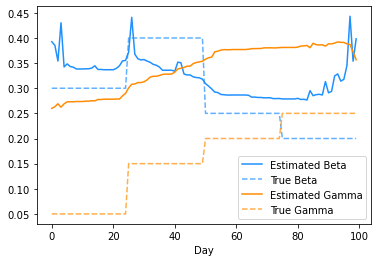

In [144]:
n_sc=3
true_beta  = np.array([[scenarios[i,(chg_pt <= t+1).sum(),0] for t in range(T)] for i in range(n_sc)])
true_gamma = np.array([[scenarios[i,(chg_pt <= t+1).sum(),1] for t in range(T)] for i in range(n_sc)])

fig, ax = plt.subplots()
plt.plot(beta_est, label="Estimated Beta", color='dodgerblue')
plt.plot(true_beta[0], label="True Beta", color='dodgerblue', linestyle='dashed', alpha=0.7)
plt.plot(gamma_est, label="Estimated Gamma", color='darkorange')
plt.plot(true_gamma[0], label="True Gamma", color='darkorange', linestyle='dashed', alpha=0.7)
ax.set_xlabel("Day")
plt.legend(loc="best")

### Agreement with True Values

In [94]:
def comp_ARI(true, estim, T_max=100):

    comb = np.array(list(itertools.combinations(range(T_max), 2))).T
    true_mask = (true[comb[0]] == true[comb[1]]).astype(int)
    estim_mask = (estim[comb[0]] == estim[comb[1]]).astype(int)

    TP = np.mean(true_mask*estim_mask)
    FP = np.mean((1-true_mask)*estim_mask)
    FN = np.mean(true_mask*(1-estim_mask))
    TN = np.mean((1-true_mask)*(1-estim_mask))
    num = TP+TN-(TP+FP)*(TP+FN)-(TN+FP)*(TN+FN)
    den = 1-(TP+FP)*(TP+FN)-(TN+FP)*(TN+FN)

    ARI = num/den

    return ARI


In [95]:
def comp_MI(true, estim, T_max=100):
    n_kkprime = np.histogram2d(true, estim, bins=(np.max(true)+1, np.max(estim)+1))[0]
    n_k = np.sum(n_kkprime, axis=1)
    n_kprime = np.sum(n_kkprime, axis=0)
    
    MI = np.sum(n_kkprime/T_max*np.log((n_kkprime+(n_kkprime==0))*T_max/np.outer(n_k, n_kprime)))
    return MI

In [96]:
ARI = comp_ARI(stage_true, stage_est)
MI = comp_MI(stage_true, stage_est)
print(f"ARI = {ARI} out of 1\nMI = {MI} out of 1.386")

ARI = 0.4195186575402957 out of 1
MI = 0.5800262886080637 out of 1.386


# TEST

In [51]:
beta_hat = np.array([ 1712591.09728849, 2421667.22702725, 7949879.87022826, 7999122.89703909, 12141976.560411, 10082084.0026335, 23659778.6331471, 11476513.1881935, 8495142.19340024, 25768089.7074787, 6867509.82252224, 350394.590716053, 4703631.48519684, 180152194.995728, 16300696.0650598, 99585876.2837862, 191400702.885143, 242676632.143437, 54164618.4033595, 163504080.753535, 214081034.818111, 85922641.3180205, 375202285.794401, 155206881.47779, 94855984.6772341, 583282857.592128, 835946072.141496, 2366665020.21145, 376089966.634354, 647344572.078688, 145927336.104224, 2789291849.64849, 1867559232.19695, 5732984656.69773, 8285192552.52253, 10275719044.572, 29643997167.3225, 7400541083.84276, 16522115377.3897, 24202965073.0552, 13798982433.8166, 18347282055.7084, 39075872186.9553, 5429988566.20737, 69788380808.7137, 42645359532.2387, 29880023164.1556, 7619304044.73591, 15501030897.4832, 23271586397.6569, 27177353910.9366, 1889983689.38727, 9207844140.1367, 3251835520.75016, 93867319.9620979, 1387108851.6171, 1485099663.62176, 14920792312.4467, 6234186500.10806, 892827935.139121, 187752838.989448, 204477408.196938, 6569782403.90293, 173678268.890536, 58984487.6088467, 1921729323.6275, 2997157243.66125, 1248944026.05108, 928211393.912346, 132402855.228644, 208781542.275392, 40065805.9348842, 1069209716.787, 28966633.1882339, 132085572.617782, 329281150.216695, 166869313.264091, 7913345.42727628, 113692406.148511, 27210784.9327443, 35442543.5999369, 34120479.1692604, 56139172.7108659, 1836004.24825654, 24887386.3506362, 42588729.4429431, 1637735.35530973, 2062173.66721819, 3363446.02462344, 457526.78789022, 1226946.74723875, 1352494.29231248, 377721.128853879, 2000758.69139188, 3675393.00488053, 394852.46736389, 0.258750538050435, 6501764.9409783, 0.256697341511641, 0.073650925695881])
gamma_hat = np.array([ 0.0818653576653675, 0.0678757900513179, 0.0723166481678754, 0.035717899309638, 0.0516037593079068, 0.0786847853645978, 0.0176777633098201, 0.0710897887360672, 0.0516122619238952, 0.0677302250996445, 0.0670702047773683, 0.0556013614281389, 0.0351418847199749, 0.0504832622191839, 0.043165007960339, 0.0400331270415426, 0.0597117593285449, 0.0542411699496413, 0.0541293978643313, 0.043715413741898, 0.04477936525309, 0.0488168884443922, 0.0518199296611104, 0.051442657537367, 0.0483598310348317, 0.154762035848042, 0.155660862313439, 0.151306599999382, 0.156616723003154, 0.159197824385023, 0.149191714083472, 0.148074115784991, 0.150804995385897, 0.150078396889744, 0.150456978535452, 0.150428081736542, 0.14945832664708, 0.152021342269542, 0.148543662721606, 0.149788787954731, 0.150071254800806, 0.149494952836519, 0.150853580181227, 0.151020380195515, 0.151484802224436, 0.148369161601659, 0.151422604445744, 0.149784151731414, 0.15009388289518, 0.149883890620589, 0.201151955260156, 0.200121495293457, 0.199743130512037, 0.200743882934133, 0.20053546153536, 0.199192154086491, 0.199324400404732, 0.203369034308693, 0.196449628706691, 0.205564398847221, 0.204028652900309, 0.202914412709516, 0.203209935932227, 0.190600299791958, 0.200606421529791, 0.204954741582569, 0.203395091909088, 0.192881515347279, 0.206326484025423, 0.191004960009554, 0.208533105341, 0.202013460908219, 0.211999711625655, 0.203373847815118, 0.198396879356857, 0.251039436309064, 0.254343863624969, 0.250724725029029, 0.249116516601989, 0.277959118835536, 0.240087550675436, 0.288587832130091, 0.265648165899834, 0.293809193059354, 0.243879446635407, 0.288286400997221, 0.248815209624875, 0.253742908807798, 0.330536719838308, 0.245679294531494, 0.316942263332094, 0.217193983676748, 0.434728498553259, 0.254303259290482, 0.15060766187724, 0.413061696331678, 0.251861604116306, 0.377412936840824, 0.27060474067245, 0.324005318217907])


In [55]:
T_max = 100
change_type = 1
Delta_hat = np.zeros(shape=(T_max), dtype=int)
Delta_hat[0] = 1
Delta_hat_candidate = np.zeros(shape=(T_max), dtype=int)
Delta_hat_candidate[0]  = 1
Delta_hat_candidate[4] = 1
Stage_hat = np.cumsum(Delta_hat)-1
Stage_hat_candidate = np.cumsum(Delta_hat_candidate)-1
K_hat = np.sum(Delta_hat, dtype=int)

print(np.where(Delta_hat==1)[0])
print(np.where(Delta_hat_candidate==1)[0])
print(Stage_hat)
print(Stage_hat_candidate)

[0]
[0 4]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [53]:
change_type = 1
p = 0.01
###### proposal phase
'''
if change_type != 0:
    if change_type == 1:
        print("Add")
        possible_change_indices = np.where(Delta_hat[1:] == 0)[0]+1
        print(possible_change_indices)
    if change_type == -1:
        print("Drop")
        possible_change_indices = np.where(Delta_hat[1:] == 1)[0]+1
        
    index_to_change = np.random.choice(possible_change_indices)
        
    Delta_hat_candidate[index_to_change] = 1 - Delta_hat_candidate[index_to_change]
    Stage_hat_candidate = np.cumsum(Delta_hat_candidate)-1
        
else:
    print("Swap")
    possible_change_indices = np.where(np.abs(Delta_hat[1:-1] - Delta_hat[2:]) == 1)[0]+1
    one_index = Delta_hat[possible_change_indices]
    index_to_change = np.random.choice(possible_change_indices)
    Delta_hat_candidate[index_to_change + np.array([0, 1])] = Delta_hat_candidate[index_to_change + np.array([1, 0])]
    Stage_hat_candidate = np.cumsum(Delta_hat_candidate)-1

print(index_to_change)
'''
print("Original:",np.where(Delta_hat==1)[0])
print("Candidate:",np.where(Delta_hat_candidate==1)[0])
print("---------------------------")
########## metropolis hastings phase
#compute pi(delta*)/pi(delta^g)
pi = (p/(1-p))**(np.sum(Delta_hat_candidate - Delta_hat))
    
#compute J/J
JJ = 0
delta_sum_candidate = np.sum(Delta_hat_candidate)
delta_sum = np.sum(Delta_hat)
if delta_sum == delta_sum_candidate:
    JJ = 1 
elif ([delta_sum_candidate, delta_sum] == [1, 2] or [delta_sum_candidate, delta_sum] == [T_max, T_max-1]):
    JJ = 3/(T_max-1)
elif ([delta_sum_candidate, delta_sum] == [2, 1] or [delta_sum_candidate, delta_sum] == [T_max-1, T_max]):
    JJ = (T_max-1)/3
elif delta_sum_candidate - delta_sum == -1 and (delta_sum_candidate != 1 and delta_sum_candidate != T_max-1):
    JJ = (delta_sum-1)/(T_max - delta_sum_candidate)
elif delta_sum_candidate - delta_sum == 1 and (delta_sum_candidate != 2 and delta_sum_candidate != T_max):
    JJ = (T_max - delta_sum)/(delta_sum_candidate-1)
#compute pi(beta,gamma|delta*)/pi(beta,gamma|delta)
log1_candidate = 0
log2_candidate = 0
    
for k in range(np.sum(Delta_hat_candidate)):
    ind_k = np.where(Stage_hat_candidate == k)[0]
    
    print(k, len(ind_k))
    log1_candidate += np.log(gammaFunc(0.1+len(ind_k))) - (0.1+len(ind_k))*np.log(0.1+np.sum(beta_hat[ind_k]))
    log2_candidate += np.log(gammaFunc(0.1+len(ind_k))) - (0.1+len(ind_k))*np.log(0.1+np.sum(-np.log(gamma_hat[ind_k])))
    
log1_original = 0
log2_original = 0
                                 
for k in range(np.sum(Delta_hat)):
    ind_k = np.where(Stage_hat == k)[0]
    
    print(k, len(ind_k))
    log1_original += np.log(gammaFunc(0.1+len(ind_k))) - (0.1+len(ind_k))*np.log(0.1+np.sum(beta_hat[ind_k]))
    log2_original += np.log(gammaFunc(0.1+len(ind_k))) - (0.1+len(ind_k))*np.log(0.1+np.sum(-np.log(gamma_hat[ind_k])))
    
log_final = (log1_candidate+log2_candidate) - (log1_original+log2_original)
print("log pi:", np.log(pi))
print("log intermediate:", log_final)     
print("log JJ:",  np.log(JJ))
print("log m_mh:", np.log(pi)+np.log(JJ)+log_final)
intermediate_ratio = np.exp(log_final)
m_mh = intermediate_ratio*JJ*pi
ratio = min(1.,m_mh)
print("pi:", pi)
print("intermediate_ratio:", intermediate_ratio)
print("JJ:", JJ)
print("m_mh:", m_mh)
print("ratio:", ratio)
print("log likelihood_original:",(log1_original+log2_original))
cxx = np.random.binomial(1, ratio) 


Original: [0]
Candidate: [0 4]
---------------------------
0 4
1 96
0 100
log pi: -4.59511985013459
log intermediate: 22.52716804764941
log JJ: 3.4965075614664802
log m_mh: 21.4285557589813
pi: 0.010101010101010102
intermediate_ratio: 6073300583.210301
JJ: 33.0
m_mh: 2024433527.7367673
ratio: 1.0
log likelihood_original: -2496.7495910345087


In [57]:
index_to_change = 4
b_shape = 0.1
b_rate = 0.1
r_shape = 0.1
r_rate = 0.1

gamma_b_shape = gammaFunc(b_shape)
gamma_r_shape = gammaFunc(r_shape)

p_a = 1/T_max**4
p_b = 2 - p_a

if change_type == 1:
    possible_change_indices = np.where(Delta_hat[1:] == 0)[0]+1
elif change_type == -1:
    possible_change_indices = np.where(Delta_hat[1:] == 1)[0]+1
index_to_change = 4

if change_type == 1:
    possible_change_indices_candidate = np.where(Delta_hat_candidate[1:] == 1)[0] + 1
    phase_original  = np.array([Stage_hat[index_to_change]])
    phase_candidate = np.array([Stage_hat[index_to_change], Stage_hat_candidate[index_to_change]])
elif change_type == -1:
    possible_change_indices_candidate = np.where(Delta_hat_candidate[1:] == 0)[0] + 1
    phase_original  = np.array([Stage_hat[index_to_change], Stage_hat_candidate[index_to_change]])
    phase_candidate = np.array([Stage_hat_candidate[index_to_change]])
logp_original = 0
logp_candidate = 0
for i in phase_original:
    L_i_original = np.where(Stage_hat == i)[0]
    logp_original += np.sum(np.log(np.arange(1, len(L_i_original)) - 1 + b_shape)) \
                   - np.log(gamma_b_shape) + b_shape * np.log(b_rate) \
                   - (b_shape + len(L_i_original)) * np.log(b_rate + np.sum(beta_hat[L_i_original]))
    logp_original += np.sum(np.log(np.arange(1, len(L_i_original)) - 1 + r_shape)) \
                   - np.log(gamma_r_shape) + r_shape * np.log(r_rate) \
                   - (r_shape + len(L_i_original)) * np.log(r_rate + np.sum(-np.log(gamma_hat[L_i_original])))
    logp_original -= np.sum(np.log(np.arange(1, len(L_i_original))))
for i in phase_candidate:
    L_i_candidate = np.where(Stage_hat_candidate == i)[0]
    logp_candidate += np.sum(np.log(np.arange(1, len(L_i_candidate)) - 1 + b_shape)) \
                    - np.log(gamma_b_shape) + b_shape * np.log(b_rate) \
                    - (b_shape + len(L_i_candidate)) * np.log(b_rate + np.sum(beta_hat[L_i_candidate]))
    logp_candidate += np.sum(np.log(np.arange(1, len(L_i_candidate)) - 1 + r_shape)) \
                    - np.log(gamma_r_shape) + r_shape * np.log(r_rate) \
                    - (r_shape + len(L_i_candidate)) * np.log(r_rate + np.sum(-np.log(gamma_hat[L_i_candidate])))
    logp_candidate -= np.sum(np.log(np.arange(1, len(L_i_candidate))))
logp_candidate += np.log(p_a / p_b) + np.log((3 - 2 * (K_hat == 1)) \
                * len(possible_change_indices) / (3 - 2 * ((K_hat + 1) == T_max)) / len(possible_change_indices_candidate))
ratio = np.exp(min([0, logp_candidate - logp_original]))

print((logp_candidate - logp_original))
print(np.exp(logp_candidate - logp_original))

11.785463814204377
131329.38217590697
